# **Importing HDB Resale Flat Prices For Each Time Period**

In [ ]:
import pandas as pd
import numpy as np

HDB_resale_flat_1990_to_1999 = pd.read_csv('Data/1990-1999.csv')
HDB_resale_flat_2000_to_Feb_2012 = pd.read_csv('Data/2000-Feb2012.csv')
HDB_resale_flat_Mar_2012_to_2014 = pd.read_csv('Data/Mar2012-2014.csv')
HDB_resale_flat_2015_to_2016 = pd.read_csv('Data/2015-2016.csv')
HDB_resale_flat_2017_onwards = pd.read_csv('Data/2017 Onwards.csv')

# Note: The "remaining lease" column is only provided for the HDB resale flat dataset from 2015 onwards. 
# However, the column can be derived for HDB resale flat transaction records before 2015 since all HDB flats have 99-year lease
HDB_resale_flat_prices_combined = pd.concat([HDB_resale_flat_1990_to_1999, HDB_resale_flat_2000_to_Feb_2012, HDB_resale_flat_Mar_2012_to_2014,
                                             HDB_resale_flat_2015_to_2016, HDB_resale_flat_2017_onwards], axis = 0)

# **Exploratory Data Analysis (EDA)**

In [ ]:
# Structure of data
HDB_resale_flat_prices_combined.info()

In [ ]:
HDB_resale_flat_prices_combined.columns

In [ ]:
HDB_resale_flat_prices_combined.head(10)

In [ ]:
HDB_resale_flat_prices_combined.tail(10)

# **Feature Engineering**

## **Standardizing the remaining lease (a combination of years and months) to the total number of months remaining in the lease**

In [ ]:
remaining_lease_years = HDB_resale_flat_prices_combined.remaining_lease.str.extract(r'(\d+) years (\d+) months')[0]
remaining_lease_months = HDB_resale_flat_prices_combined.remaining_lease.str.extract(r'(\d+) years (\d+) months')[1]
HDB_resale_flat_prices_combined["remaining_lease_months"] = (remaining_lease_years.astype(float) * 12) + remaining_lease_months.astype(float)

## **Imputing missing records into the 'remaining_lease_months' column**

In [ ]:
HDB_resale_flat_prices_combined.remaining_lease_months.fillna(
    (99 - (pd.DatetimeIndex(HDB_resale_flat_prices_combined.month).year - HDB_resale_flat_prices_combined.lease_commence_date.astype(int))) * 12, inplace = True)
# Converting all records in the "remaining_lease_months" to int
HDB_resale_flat_prices_combined.remaining_lease_months = HDB_resale_flat_prices_combined.remaining_lease_months.astype(int)
HDB_resale_flat_prices_combined.reset_index(drop = True, inplace = True)
HDB_resale_flat_prices_combined

In [ ]:
from helper_functions import reverse_lookup

# Obtained from https://www.hdb.gov.sg/about-us/history/hdb-towns-your-home 
region_dict = {'CENTRAL': ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH'],
               'NORTH': ['SEMBAWANG', 'WOODLANDS', 'YISHUN'],
               'NORTHEAST': ['ANG MO KIO', 'HOUGANG', 'PUNGGOL', 'SENGKANG', 'SERANGOON'],
               'EAST': ['BEDOK', 'PASIR RIS', 'TAMPINES'],
               'WEST': ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST', 'LIM CHU KANG']}

HDB_resale_flat_prices_combined = reverse_lookup(HDB_resale_flat_prices_combined, 'town', region_dict, 'region')
HDB_resale_flat_prices_combined

## **Encoding Storey Ranges With Median Storey Numbers**

In [ ]:
median_storey_dict = {'2': '01 TO 03', '3': '01 TO 05', '5': '04 TO 06', '8': ['07 TO 09', '06 TO 10'], '11': '10 TO 12', '13': '11 TO 15', 
                      '14': '13 TO 15', '17': '16 TO 18', '18': '16 TO 20', '20': '19 TO 21', '23': ['22 TO 24', '21 TO 25'], '26': '25 TO 27', 
                      '28': '26 TO 30', '29': '28 TO 30', '32': '31 TO 33', '33': '31 TO 35', '35': '34 TO 36', '38': ['37 TO 39',  '36 TO 40'], 
                      '41': '40 TO 42', '44': '43 TO 45', '47': '46 TO 48', '50': '49 TO 51'}
HDB_resale_flat_prices_combined = reverse_lookup(HDB_resale_flat_prices_combined, 'storey_range', median_storey_dict, 'median_storey')
HDB_resale_flat_prices_combined['median_storey'] = HDB_resale_flat_prices_combined['median_storey'].astype(int)

## **Standardizing The Naming Conventions of All Flat Models & Flat Types**

In [ ]:
print(HDB_resale_flat_prices_combined.flat_model.unique(), len(HDB_resale_flat_prices_combined.flat_model.unique()))
HDB_resale_flat_prices_combined['flat_model_standardized'] = HDB_resale_flat_prices_combined.flat_model.str.upper()
print(HDB_resale_flat_prices_combined.flat_model_standardized.unique(), len(HDB_resale_flat_prices_combined.flat_model_standardized.unique()))

In [ ]:
print(HDB_resale_flat_prices_combined.flat_type.unique())
HDB_resale_flat_prices_combined['flat_type_standardized'] = HDB_resale_flat_prices_combined.flat_type.str.replace(
    pat = r'(\w{5}) (\w{10})', repl = r'\1-\2', regex = True).str.strip('\-')
print(HDB_resale_flat_prices_combined.flat_type_standardized.unique())
HDB_resale_flat_prices_combined

## **Converting The Floor Area From Square Metres To Square Feet**

In [ ]:
import area_unit_conversion

HDB_resale_flat_prices_combined['resale_price_per_sqm'] = (HDB_resale_flat_prices_combined.resale_price/HDB_resale_flat_prices_combined.floor_area_sqm)
HDB_resale_flat_prices_combined['floor_area_sqft'] = area_unit_conversion.convert('m2', 'ft2', HDB_resale_flat_prices_combined.floor_area_sqm)
HDB_resale_flat_prices_combined['resale_price_per_sqft'] = HDB_resale_flat_prices_combined.resale_price/HDB_resale_flat_prices_combined.floor_area_sqft

## **Obtaining The Full Address By Combining The Block Number & Street Name Together**

In [ ]:
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined.block + ' ' + HDB_resale_flat_prices_combined.street_name.astype(str)

In [ ]:
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" LOR ", " LORONG ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" NTH\s?", " NORTH ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" UPP ", " UPPER ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" KG ",  " KAMPONG ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" TG ", " TANJONG ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" BT ", " BUKIT ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" C'WEALTH ", " COMMONWEALTH ", regex = True)
HDB_resale_flat_prices_combined['address'] = HDB_resale_flat_prices_combined['address'].str.replace(" NILE RD", " NILE RD, BUKIT MERAH", regex = True)

## The Following Addresses Were Geocoded Using Google Maps Platform Geocoding API Since Nominatim Geocoding API Is Unable to Handle This Addresses

In [ ]:
problematic_addresses = ['1 JLN PASAR BARU', '5 BUANGKOK STH FARMWAY 1', '24 JLN MEMBINA BARAT', '51 NILE RD, BUKIT MERAH', '54 NILE RD, BUKIT MERAH',
                         '7 KIM TIAN PL', '8 KIM TIAN PL', '120 KIM TIAN PL', '120A KIM TIAN PL', '121 KIM TIAN PL', '121A KIM TIAN PL',
                         '18 KAMPONG BAHRU HILL', '19 KAMPONG BAHRU HILL', '22 KAMPONG BAHRU HILL', '23 KAMPONG BAHRU HILL', '24 KAMPONG BAHRU HILL',
                         '5 YUNG PING RD', '6 YUNG PING RD', '159 YUNG PING RD', '160 YUNG PING RD', '161 YUNG PING RD', '162 YUNG PING RD', '163 YUNG PING RD', 
                         '687A WOODLANDS DR 75', '688B WOODLANDS DR 75', '688C WOODLANDS DR 75', '688D WOODLANDS DR 75', '688E WOODLANDS DR 75', '688F WOODLANDS DR 75',
                         '689A WOODLANDS DR 75', '689B WOODLANDS DR 75', '689C WOODLANDS DR 75', '689D WOODLANDS DR 75', '689E WOODLANDS DR 75', '689F WOODLANDS DR 75',
                         '690A WOODLANDS DR 75', '690B WOODLANDS DR 75', '690C WOODLANDS DR 75', '888A TAMPINES ST 81']

for BOON_LAY_DR in HDB_resale_flat_prices_combined['address'][HDB_resale_flat_prices_combined['address'].str.contains('BOON LAY DR')].unique():
    problematic_addresses.append(BOON_LAY_DR)

In [ ]:
problematic_indices = []
for address in problematic_addresses:
    problematic_indices.append(np.where(HDB_resale_flat_prices_combined['address'].unique() == address))
unique_addresses_cleaned = np.delete(HDB_resale_flat_prices_combined['address'].unique(), problematic_indices)

In [ ]:
import time
from helper_functions import geocoding_GoogleMaps, geocoding_Nominatim

start_geocoding = time.perf_counter()
HDB_block_lat_dict, HDB_block_lon_dict = {}, {}
for address in problematic_addresses:
    HDB_block_lat_dict[address], HDB_block_lon_dict[address] = geocoding_GoogleMaps(address)

for unique_address in unique_addresses_cleaned:
    HDB_block_lat_dict[unique_address], HDB_block_lon_dict[unique_address] = geocoding_Nominatim(unique_address)
print('Duration: {}s'.format(time.perf_counter() - start_geocoding)) 

In [ ]:
HDB_resale_flat_prices_combined['latitude'] = HDB_resale_flat_prices_combined['address'].map(HDB_block_lat_dict)
HDB_resale_flat_prices_combined['longitude'] = HDB_resale_flat_prices_combined['address'].map(HDB_block_lon_dict)

In [ ]:
HDB_resale_flat_prices_combined.to_csv('Data/HDB Resale Flat Prices/Combined & Processed.csv', index = None)

In [2]:
import pandas as pd
import numpy as np

HDB_resale_flat_prices_combined = pd.read_csv('Data/Combined & Processed.csv', index_col = None, low_memory = False)
HDB_resale_flat_prices_combined.head(10)

month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
3  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     07 TO 09   
4  1990-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   
5  1990-01  ANG MO KIO    3 ROOM   211  ANG MO KIO AVE 3     01 TO 03   
6  1990-01  ANG MO KIO    3 ROOM   202  ANG MO KIO AVE 3     07 TO 09   
7  1990-01  ANG MO KIO    3 ROOM   235  ANG MO KIO AVE 3     10 TO 12   
8  1990-01  ANG MO KIO    3 ROOM   235  ANG MO KIO AVE 3     04 TO 06   
9  1990-01  ANG MO KIO    3 ROOM   232  ANG MO KIO AVE 3     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  ...  \
0            31.0        IMPROVED                 1977        9000.0  ...   
1            31.0        IMPROVED                 1977        6000.0  ...   
2            31.0        IMPROVED                 1977        8000.0  ...   
3            31.0        IMPROVED                 1977        6000.0  ...   
4            73.0  NEW GENERATION                 1976       47200.0  ...   
5            67.0  NEW GENERATION                 1977       46000.0  ...   
6            67.0  NEW GENERATION                 1977       42000.0  ...   
7            67.0  NEW GENERATION                 1977       38000.0  ...   
8            67.0  NEW GENERATION                 1977       40000.0  ...   
9            67.0  NEW GENERATION                 1977       47000.0  ...   

      region  median_storey flat_model_standardized  flat_type_standardized  \
0  NORTHEAST             11                IMPROVED                  1 ROOM   
1  NORTHEAST              5                IMPROVED                  1 ROOM   
2  NORTHEAST             11                IMPROVED                  1 ROOM   
3  NORTHEAST              8                IMPROVED                  1 ROOM   
4  NORTHEAST              5          NEW GENERATION                  3 ROOM   
5  NORTHEAST              2          NEW GENERATION                  3 ROOM   
6  NORTHEAST              8          NEW GENERATION                  3 ROOM   
7  NORTHEAST             11          NEW GENERATION                  3 ROOM   
8  NORTHEAST              5          NEW GENERATION                  3 ROOM   
9  NORTHEAST              2          NEW GENERATION                  3 ROOM   

  resale_price_per_sqm floor_area_sqft  resale_price_per_sqft  \
0           290.322581      333.679691              26.971974   
1           193.548387      333.679691              17.981316   
2           258.064516      333.679691              23.975088   
3           193.548387      333.679691              17.981316   
4           646.575343      785.761853              60.069091   
5           686.567164      721.178687              63.784470   
6           626.865672      721.178687              58.237994   
7           567.164179      721.178687              52.691518   
8           597.014925      721.178687              55.464756   
9           701.492537      721.178687              65.171088   

                address  latitude   longitude  
0  309 ANG MO KIO AVE 1  1.364390  103.843330  
1  309 ANG MO KIO AVE 1  1.364390  103.843330  
2  309 ANG MO KIO AVE 1  1.364390  103.843330  
3  309 ANG MO KIO AVE 1  1.364390  103.843330  
4  216 ANG MO KIO AVE 1  1.366209  103.841476  
5  211 ANG MO KIO AVE 3  1.369205  103.841719  
6  202 ANG MO KIO AVE 3  1.368461  103.844515  
7  235 ANG MO KIO AVE 3  1.368739  103.848851  
8  235 ANG MO KIO AVE 3  1.368739  103.848851  
9  232 ANG MO KIO AVE 3  1.368527  103.837027  

[10 rows x 22 columns]

## **Summary Statistics Of Dataset Including Derived Variables**

In [3]:
HDB_resale_flat_prices_combined.info()
HDB_resale_flat_prices_combined.loc[:, HDB_resale_flat_prices_combined.columns != 'lease_commence_date'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892418 entries, 0 to 892417
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   month                    892418 non-null  object 
 1   town                     892418 non-null  object 
 2   flat_type                892418 non-null  object 
 3   block                    892418 non-null  object 
 4   street_name              892418 non-null  object 
 5   storey_range             892418 non-null  object 
 6   floor_area_sqm           892418 non-null  float64
 7   flat_model               892418 non-null  object 
 8   lease_commence_date      892418 non-null  int64  
 9   resale_price             892418 non-null  float64
 10  remaining_lease          183368 non-null  object 
 11  remaining_lease_months   892418 non-null  int64  
 12  region                   892418 non-null  object 
 13  median_storey            892418 non-null  int64  
 14  flat

floor_area_sqm  resale_price  remaining_lease_months  median_storey  \
count   892418.000000  8.924180e+05           892418.000000  892418.000000   
mean        95.709227  3.106401e+05              976.718090       7.646910   
std         25.904950  1.619536e+05              124.891342       4.768582   
min         28.000000  5.000000e+03              516.000000       2.000000   
25%         73.000000  1.900000e+05              900.000000       5.000000   
50%         93.000000  2.890000e+05              996.000000       8.000000   
75%        113.000000  4.050000e+05             1080.000000      11.000000   
max        307.000000  1.418000e+06             1212.000000      50.000000   

       resale_price_per_sqm  floor_area_sqft  resale_price_per_sqft  \
count         892418.000000    892418.000000          892418.000000   
mean            3206.550200      1030.200818             297.899629   
std             1426.189761       278.837280             132.497973   
min              161.290323       301.388108              14.984430   
25%             2269.230769       785.761853             210.819405   
50%             2890.109890      1001.039073             268.501227   
75%             4042.553191      1216.316293             375.567205   
max            14731.182800      3304.505327            1368.577948   

            latitude      longitude  
count  892418.000000  892418.000000  
mean        1.361529     103.839445  
std         0.041681       0.073722  
min         1.270369     103.685206  
25%         1.333670     103.773297  
50%         1.354788     103.843656  
75%         1.382078     103.897814  
max         1.457845     103.987631

# **Visualisations**

## **Histogram Plots - To Understand The Statistical Distribution of Each Variable**

### **Predictor Variables**

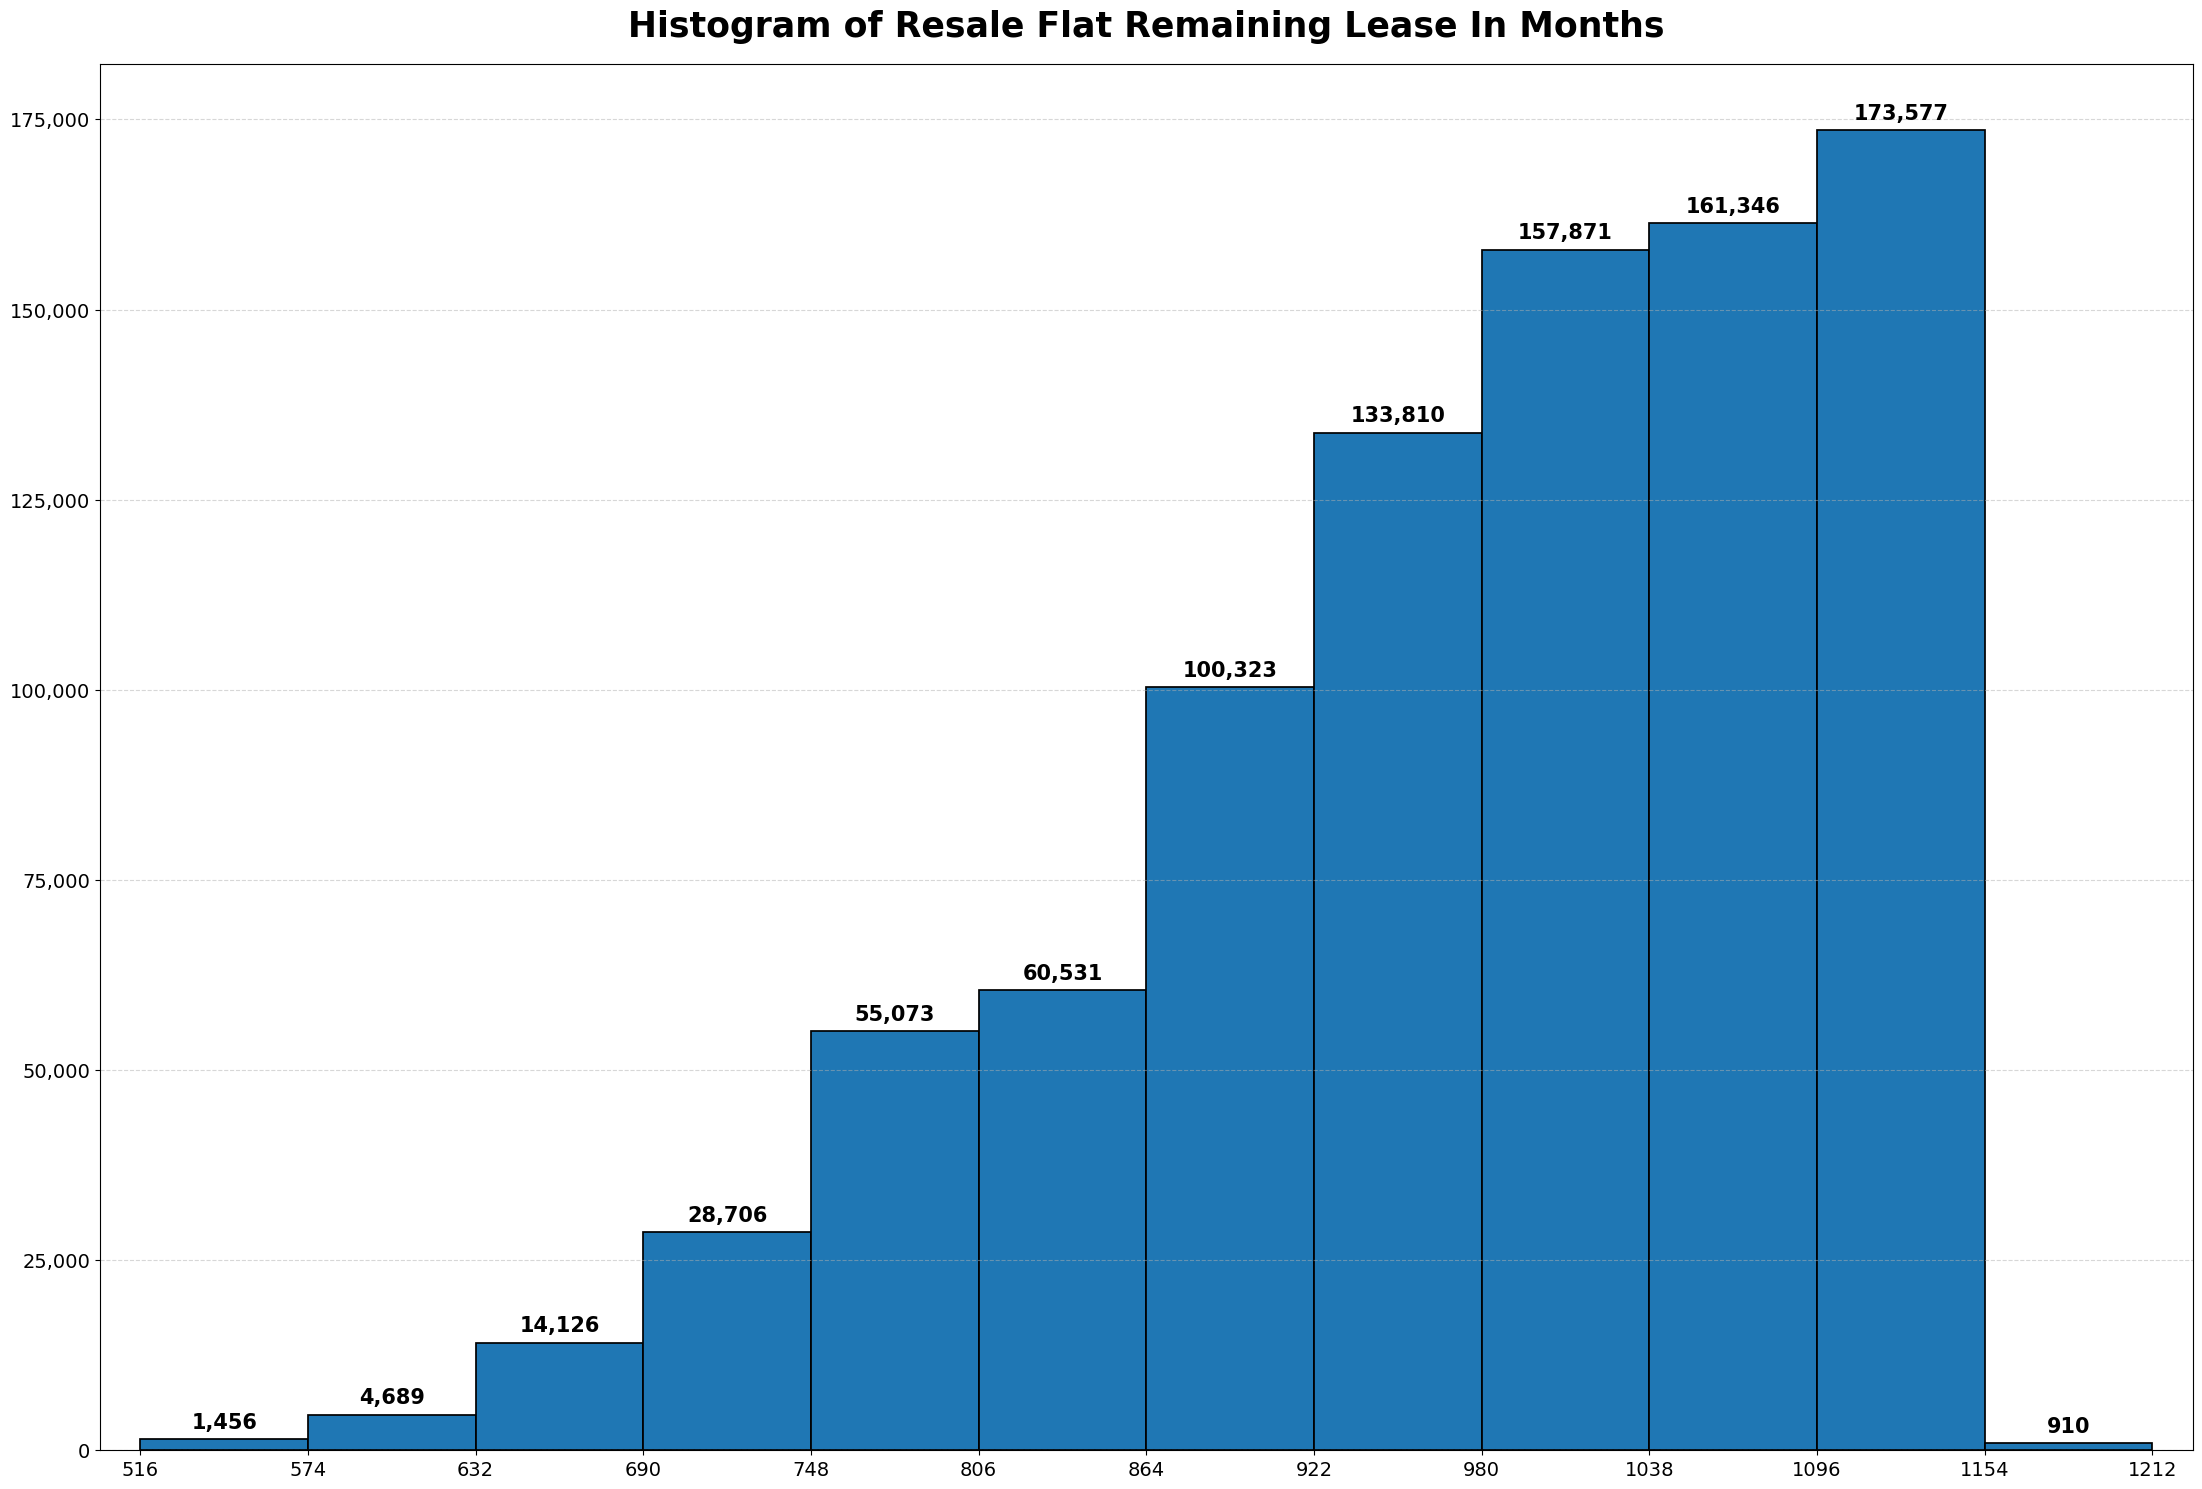

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
import seaborn as sns

plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.remaining_lease_months), bins = 12, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flat Remaining Lease In Months', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins)
# plt.yticks(np.linspace(0, 180000, 19))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 15, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
# plt.savefig('Plots/Histograms/Remaining Leases (Months) of Resale Flats.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

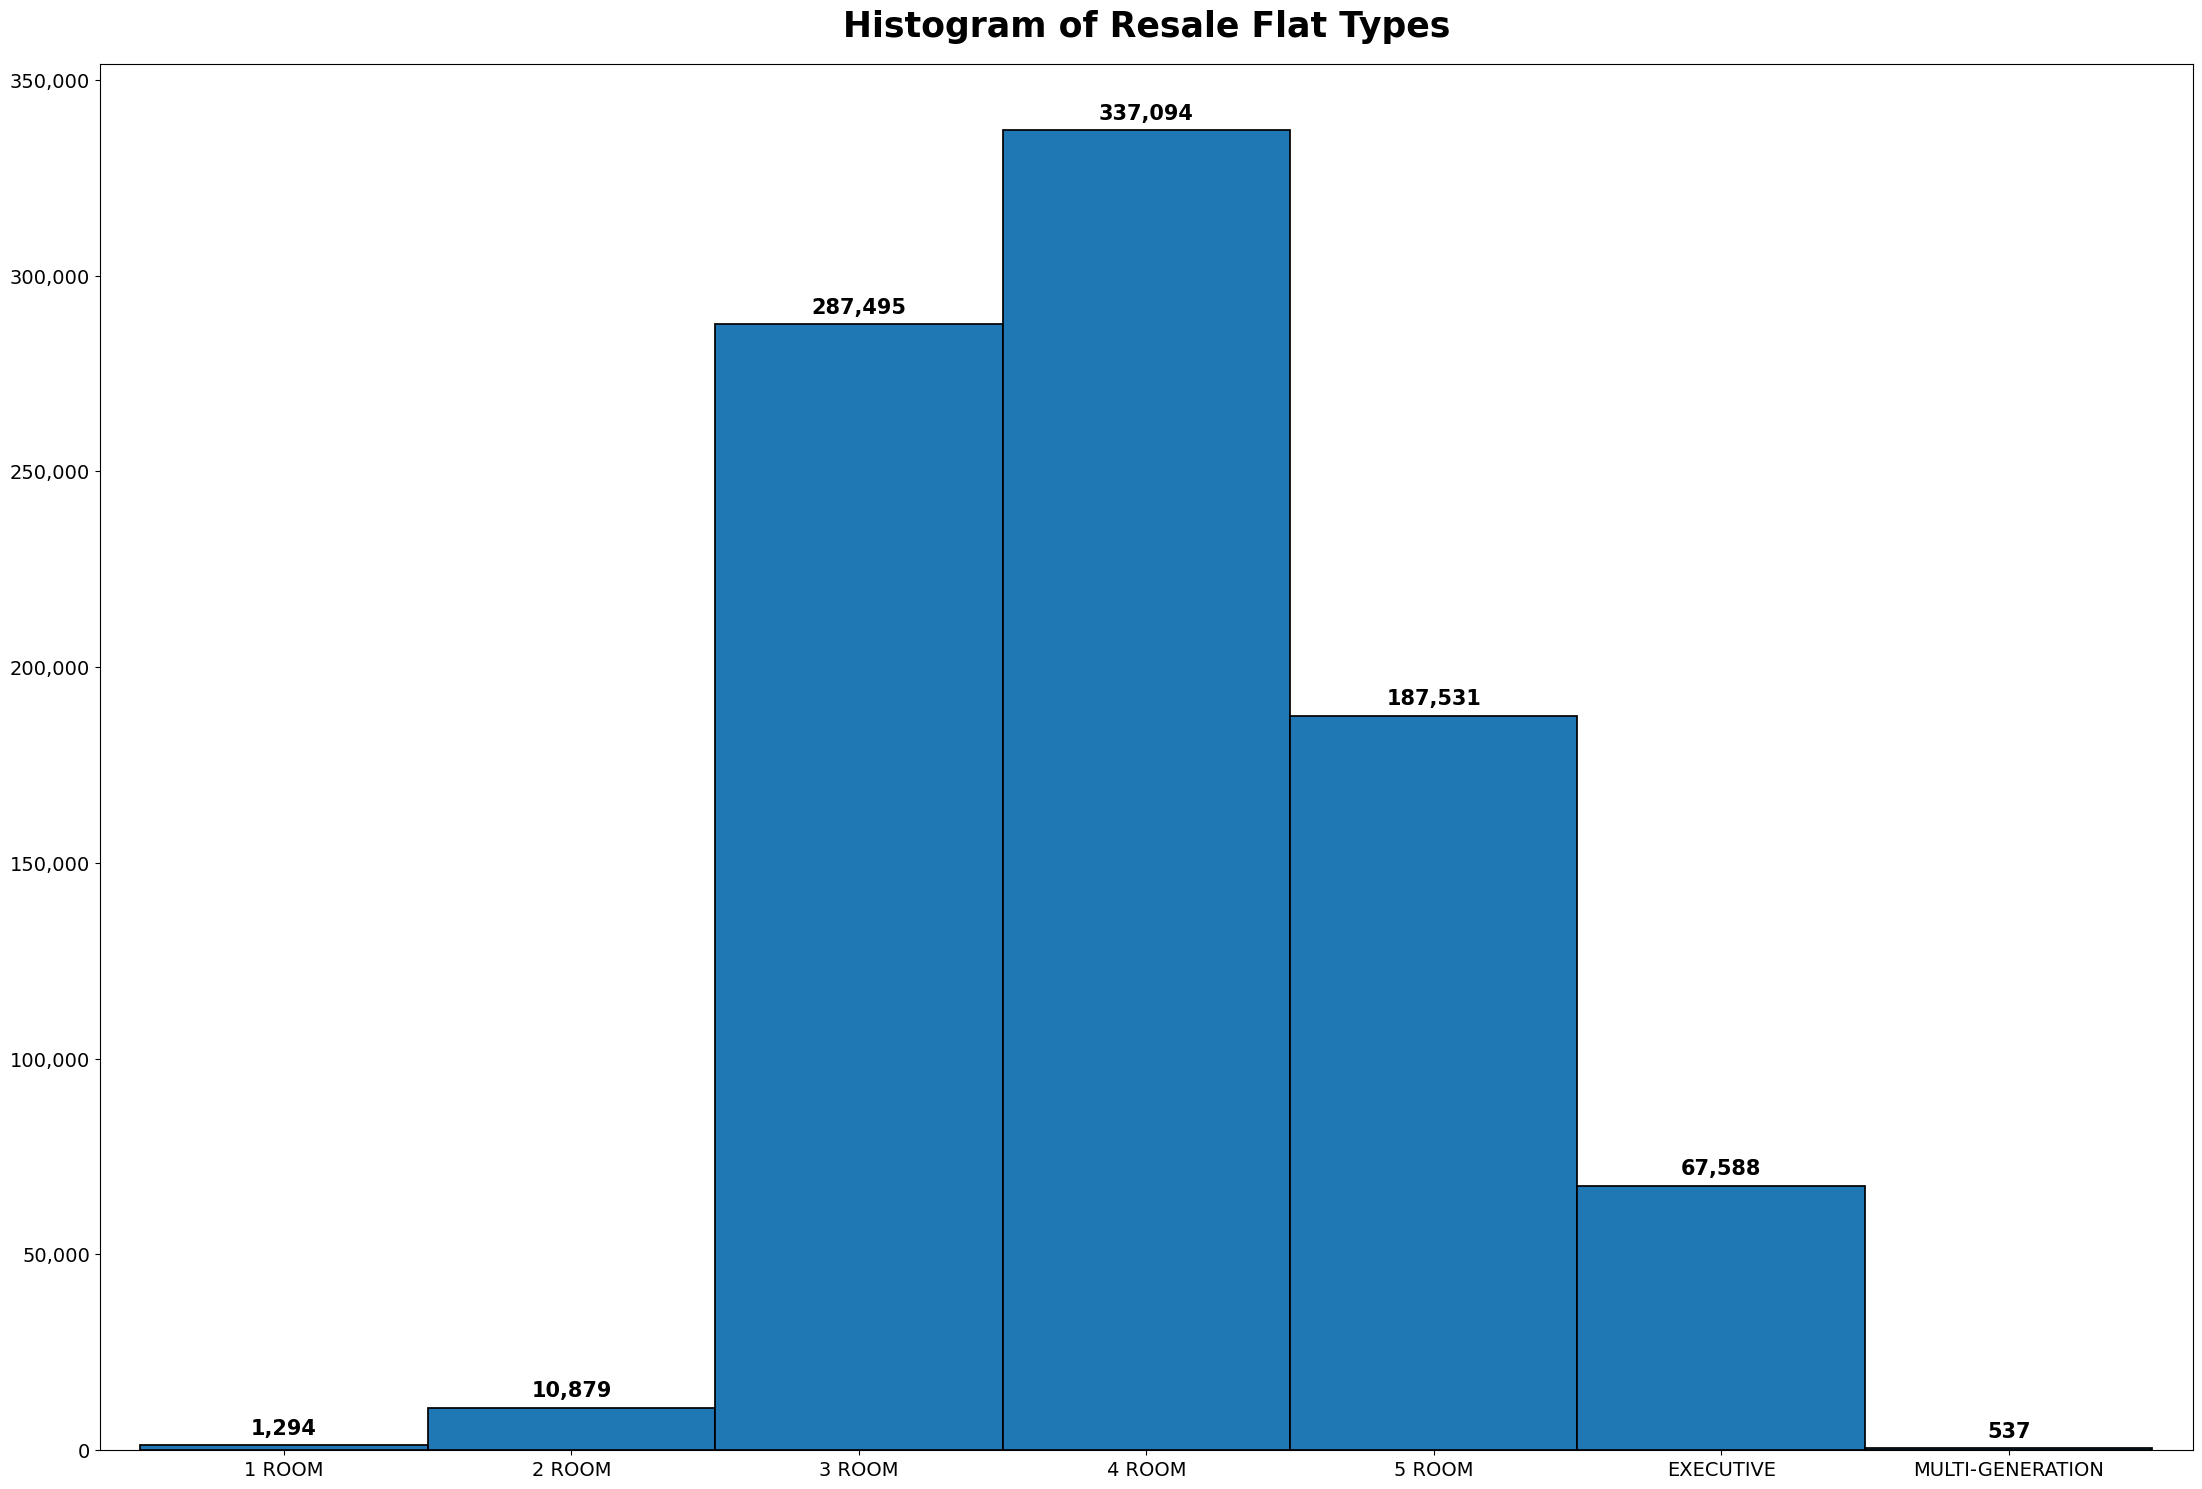

In [5]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.flat_type_standardized), bins = 7, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flat Types', size = 25, weight = 'bold', pad = 20)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], sorted(HDB_resale_flat_prices_combined.flat_type_standardized.unique()))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 15, weight = 'bold')
plt.savefig('Plots/Histograms/Resale Flat Types.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

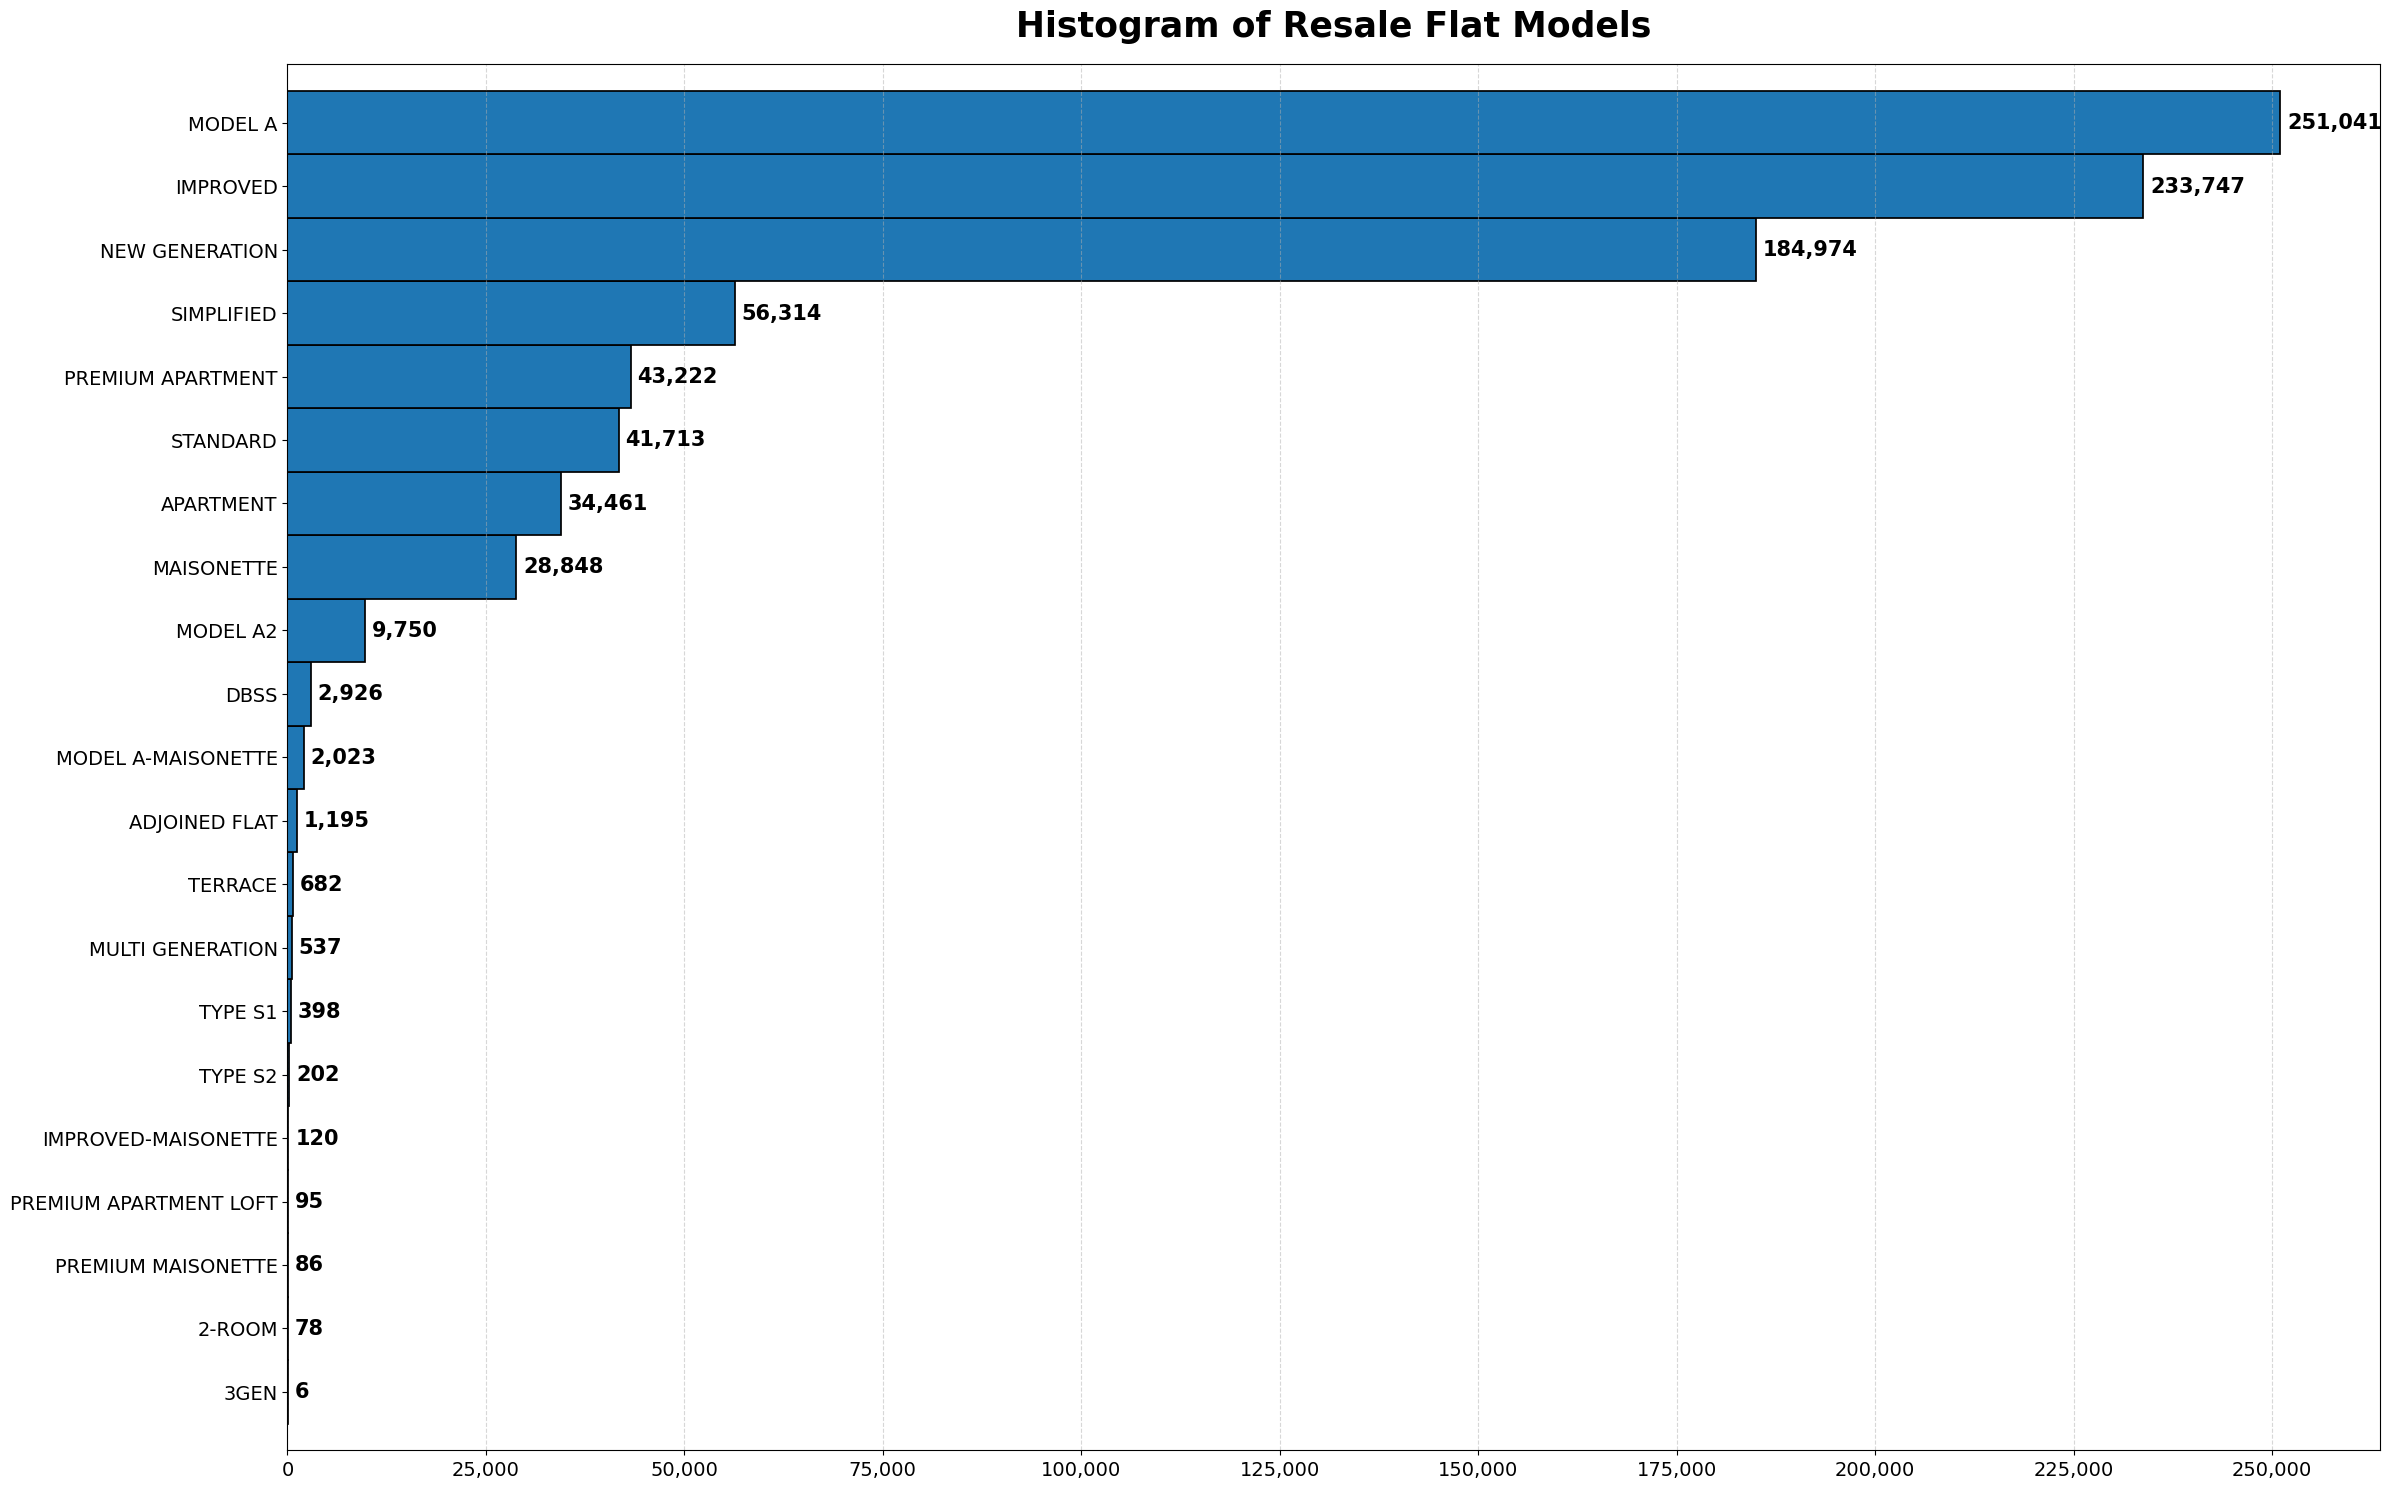

In [6]:
plt.figure(figsize = (27, 18))
plt.margins(y = 0.02, tight = True)
counts_flat_models_sorted = HDB_resale_flat_prices_combined.flat_model_standardized.value_counts(ascending = True)
horizontal_bars = plt.barh(counts_flat_models_sorted.index, counts_flat_models_sorted.values, height = 1.0, edgecolor = 'black', linewidth = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flat Models', size = 25, weight = 'bold', pad = 20)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(np.linspace(0, 250000, 11))
plt.bar_label(horizontal_bars, labels = [f'{counts:,.0f}' for counts in counts_flat_models_sorted.values], padding = 5, size = 15, weight = 'bold')
plt.grid(which = 'both', axis = 'x', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Models.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

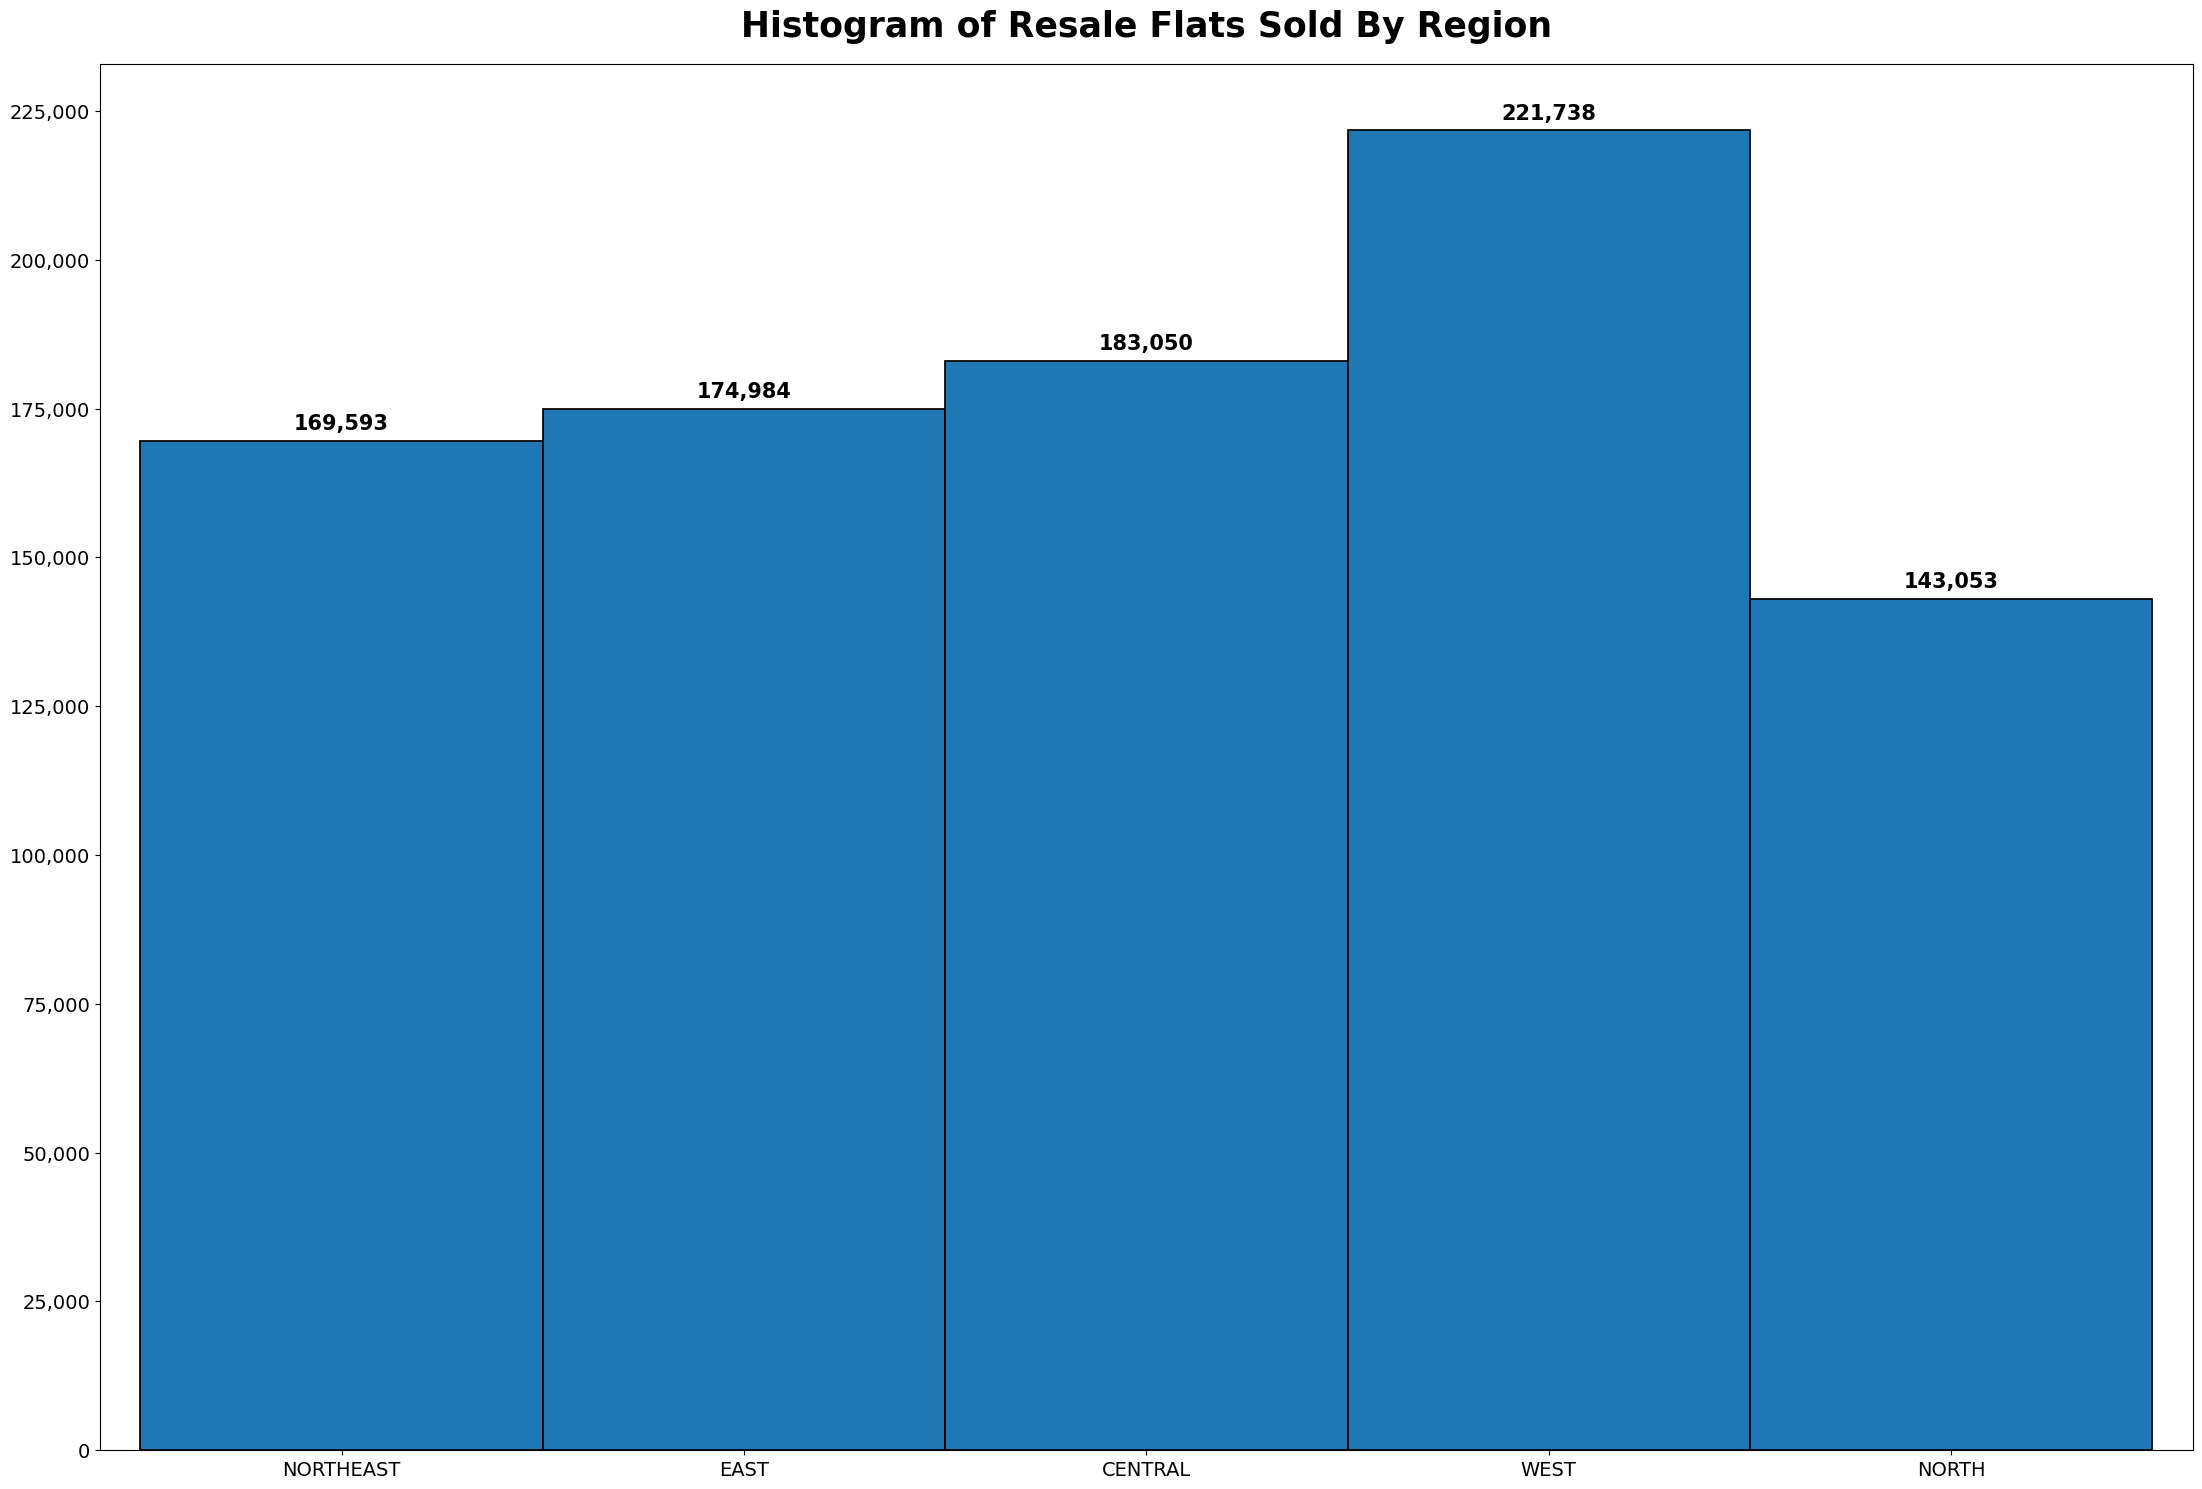

In [7]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(HDB_resale_flat_prices_combined.region, bins = 5, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Region', size = 25, weight = 'bold', pad = 20)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], HDB_resale_flat_prices_combined.region.unique())
plt.yticks(np.linspace(0, 225000, 10))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 15, weight = 'bold')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold By Region.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

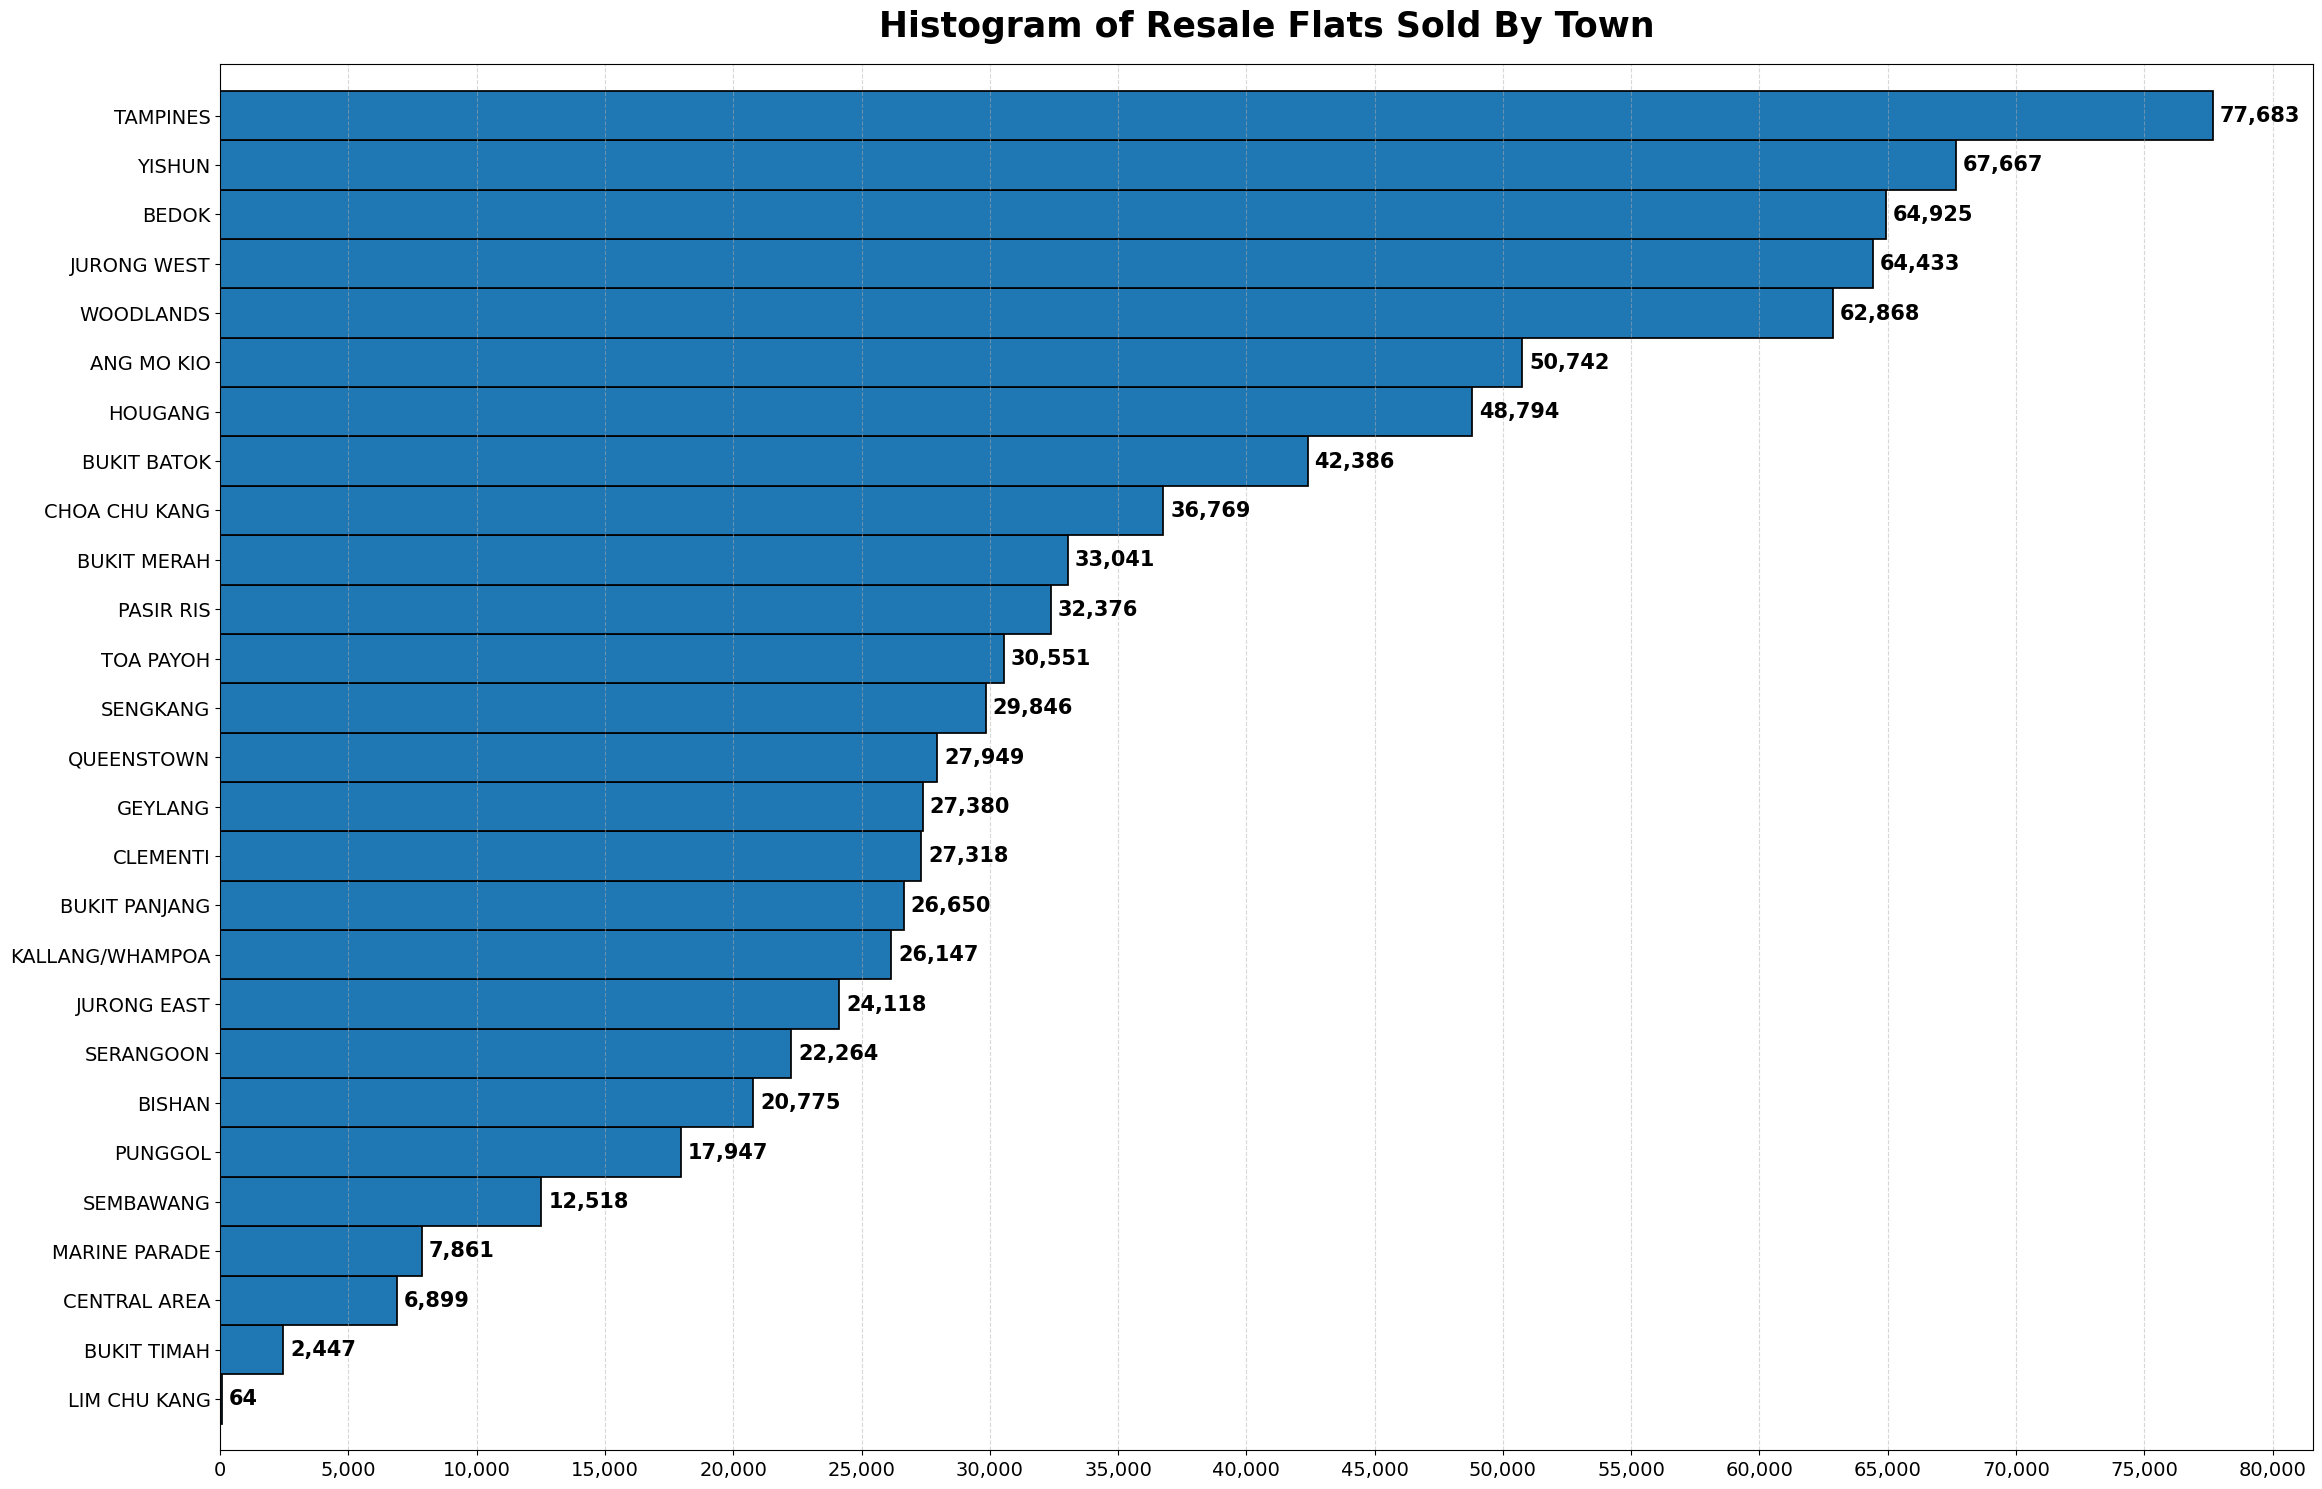

In [8]:
plt.figure(figsize = (27, 18))
plt.margins(y = 0.02, tight = True)
resale_flat_sold_town_sorted = HDB_resale_flat_prices_combined.town.value_counts(ascending = True)
horizontal_bars = plt.barh(resale_flat_sold_town_sorted.index, resale_flat_sold_town_sorted.values, height = 1.0, edgecolor = 'black', 
                           linewidth = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Town', size = 25, weight = 'bold', pad = 20)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(np.linspace(0, 80000, 17))
plt.bar_label(horizontal_bars, labels = [f'{counts:,.0f}' for counts in resale_flat_sold_town_sorted.values], padding = 5, size = 15, weight = 'bold')
plt.grid(which = 'both', axis = 'x', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold by Town.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

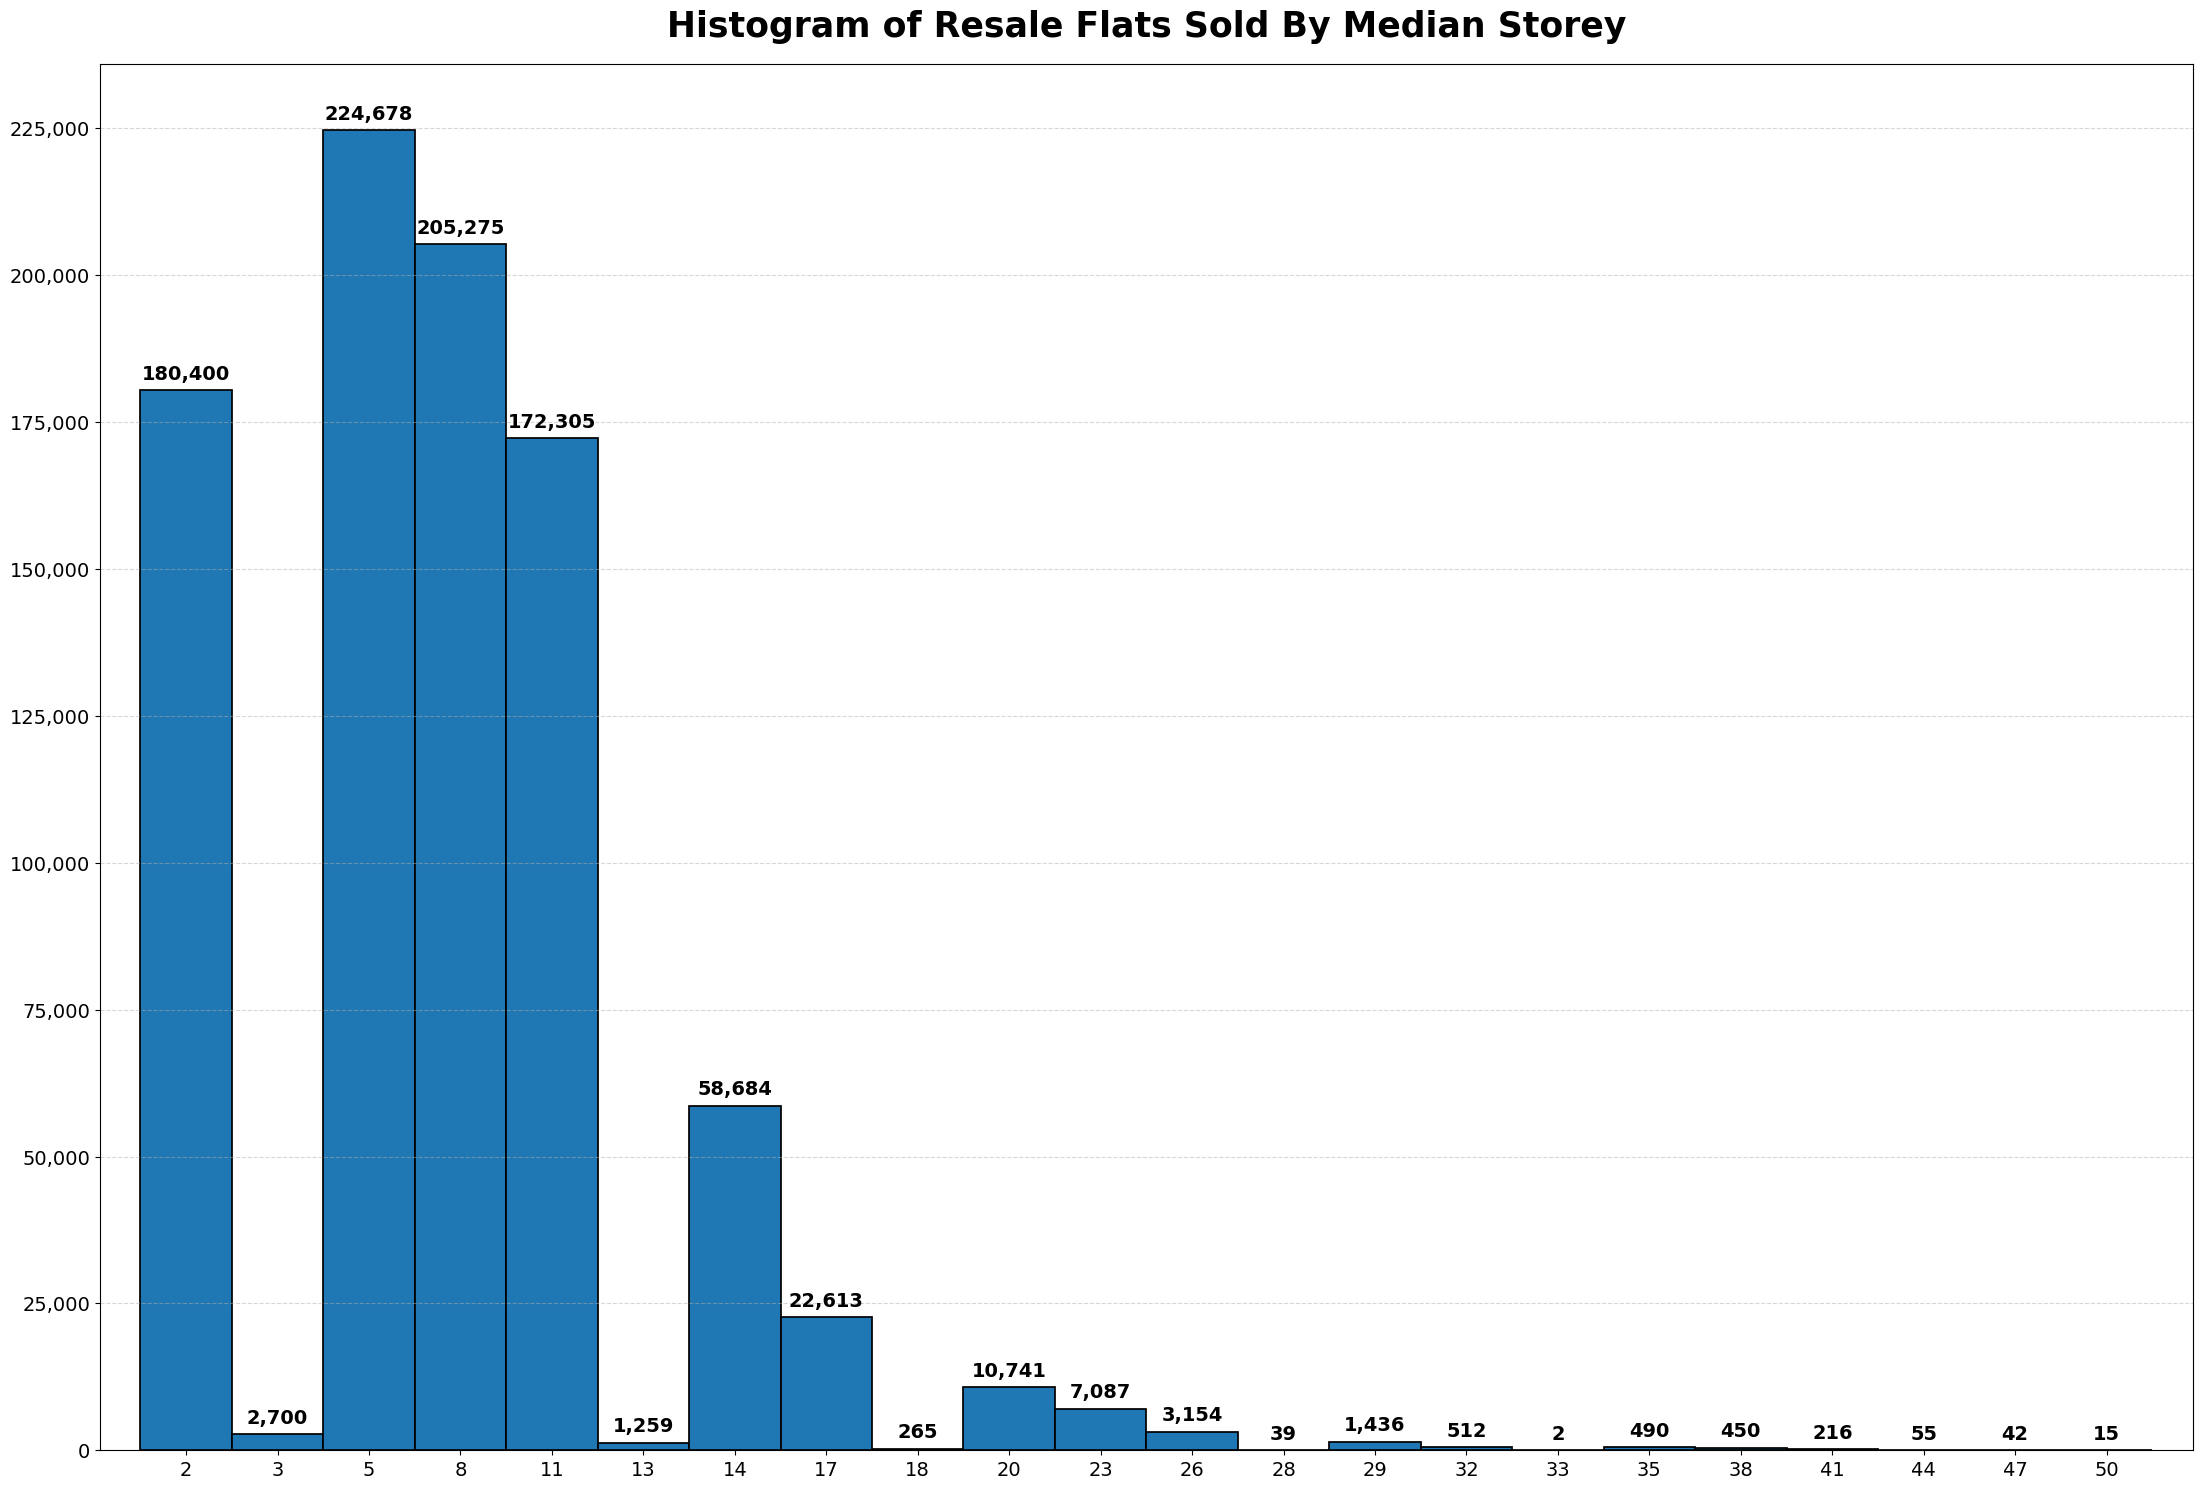

In [9]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
# Convert the median_storey column from a column of integers to a column of strings which acts as a form of a bucket
n, bins, containers = plt.hist([str(median_storey) for median_storey in sorted(HDB_resale_flat_prices_combined.median_storey)], bins = 22, 
                               edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Median Storey', size = 25, weight = 'bold', pad = 20)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], sorted(HDB_resale_flat_prices_combined.median_storey.unique()))
plt.yticks(np.linspace(0, 225000, 10))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 14, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold By Median Storey.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

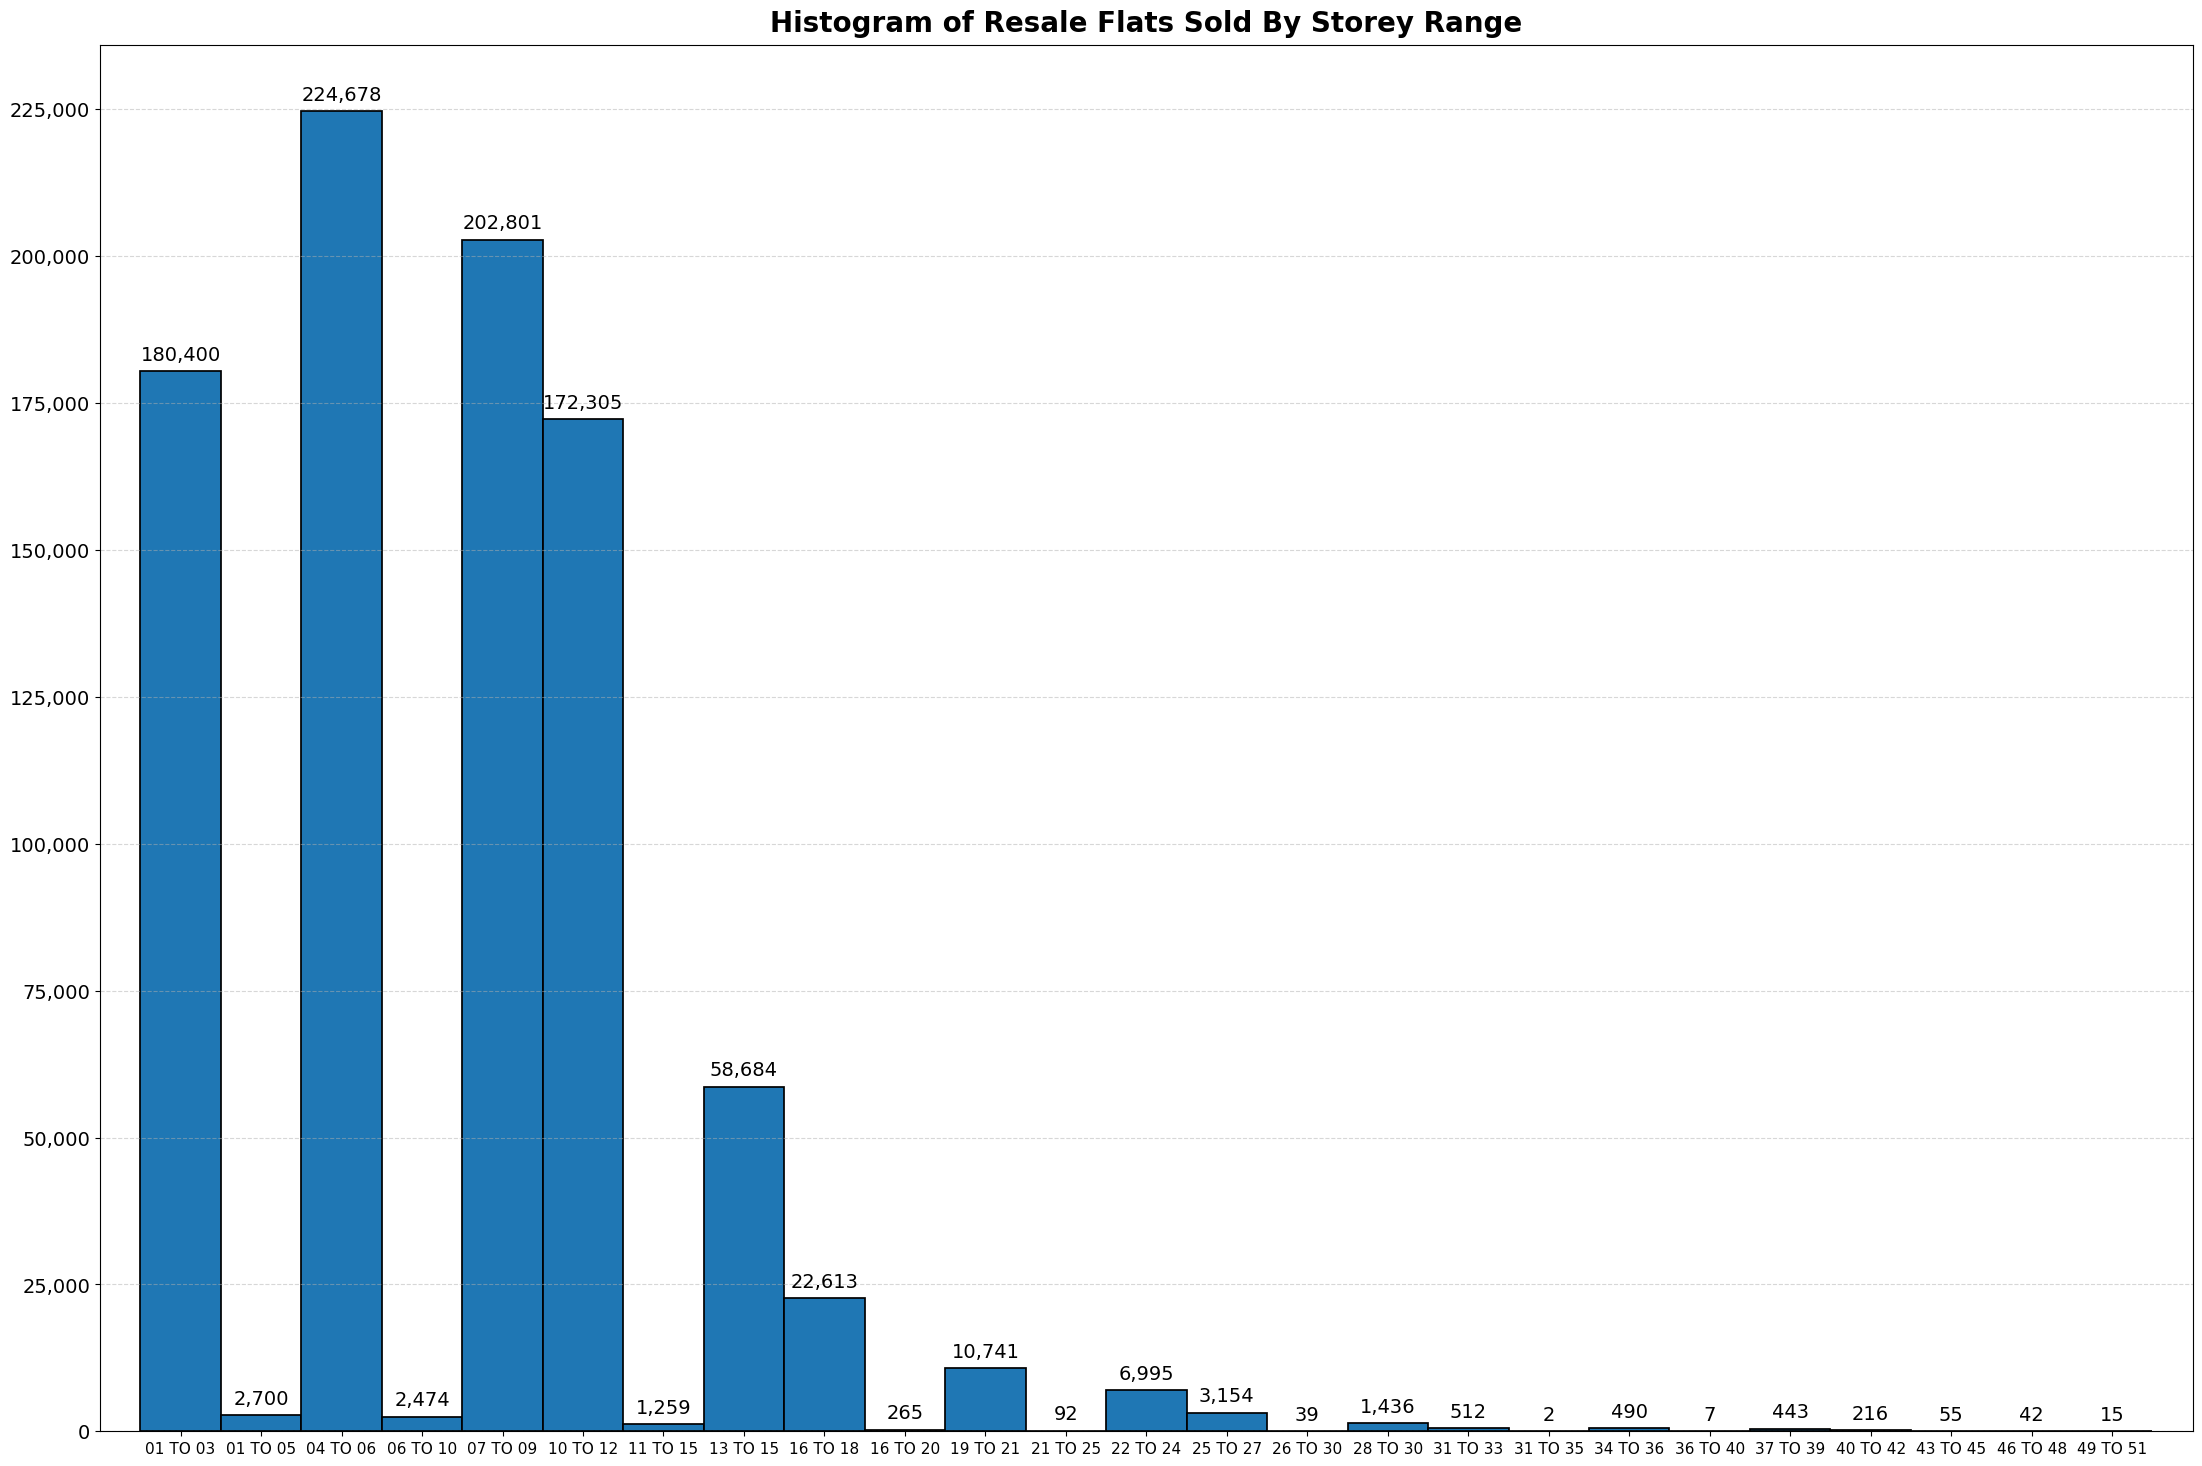

In [10]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.storey_range), bins = 25, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flats Sold By Storey Range', size = 20, weight = 'bold', pad = 10)
plt.xticks([(container._x0 + (container._x0 + container._width))/2 for container in containers], sorted(HDB_resale_flat_prices_combined.storey_range.unique()),
          size = 11)
plt.yticks(np.linspace(0, 225000, 10))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5)
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.show()

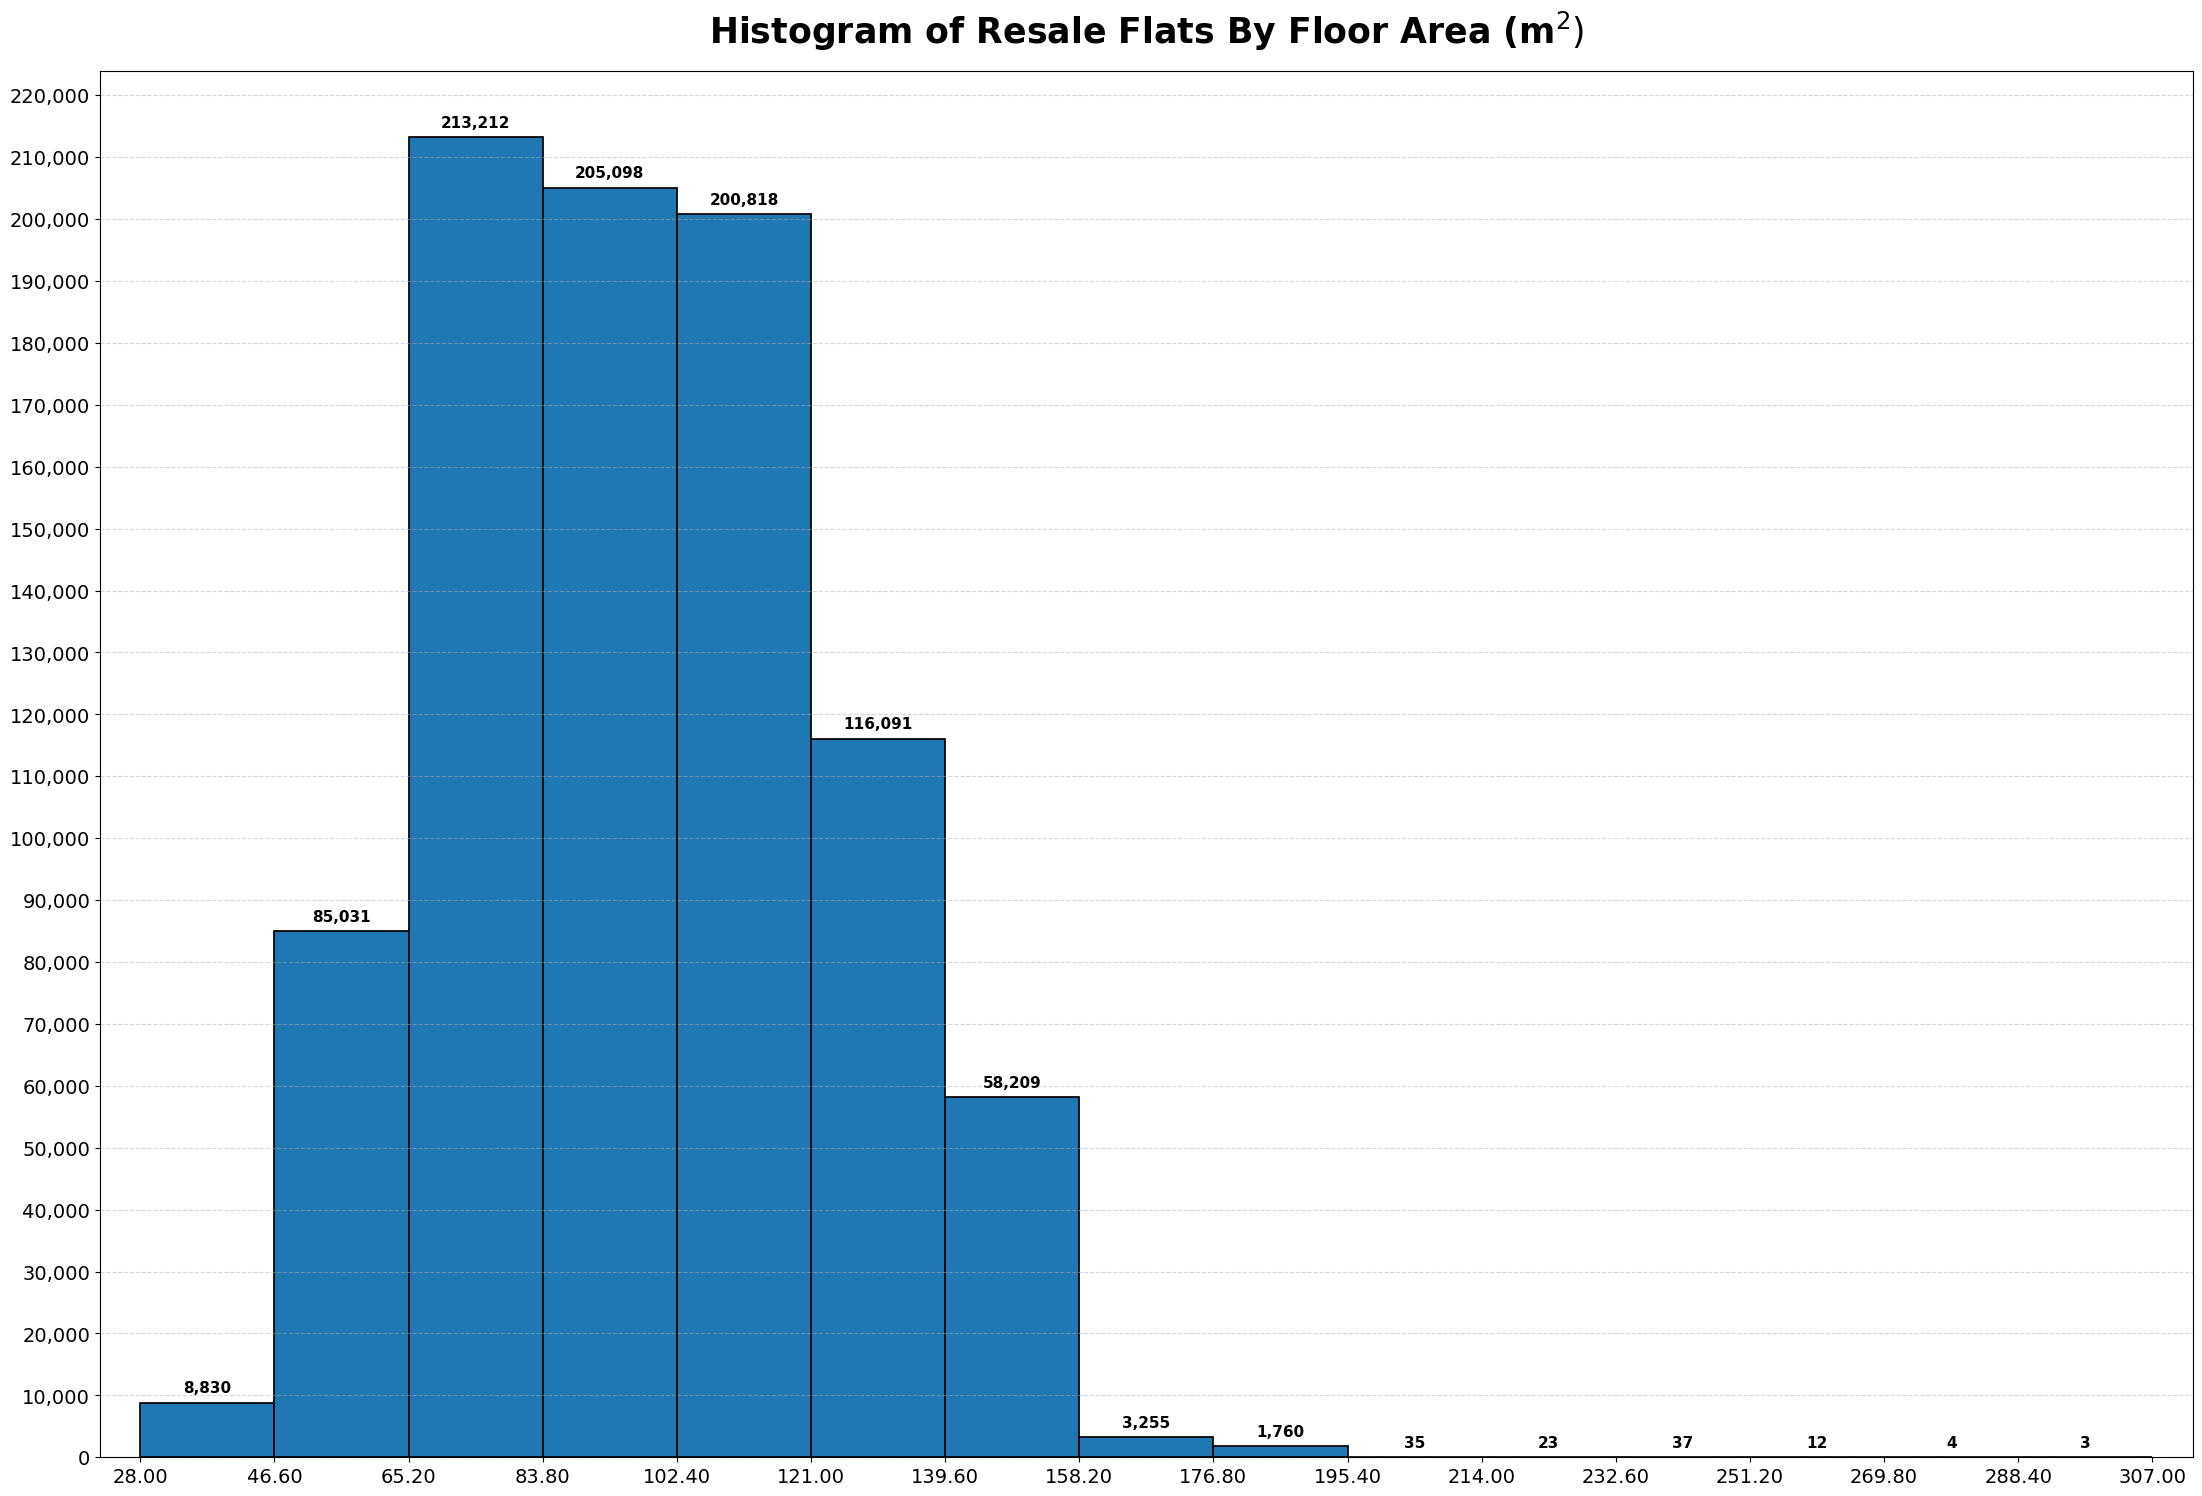

In [11]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.floor_area_sqm), bins = 15, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flats By Floor Area (m$^{2})$', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.2f}'))
plt.yticks(np.linspace(0, 220000, 23))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Number of Resale Flats Sold By Floor Area (Square Metre).jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

### **Response Variables**

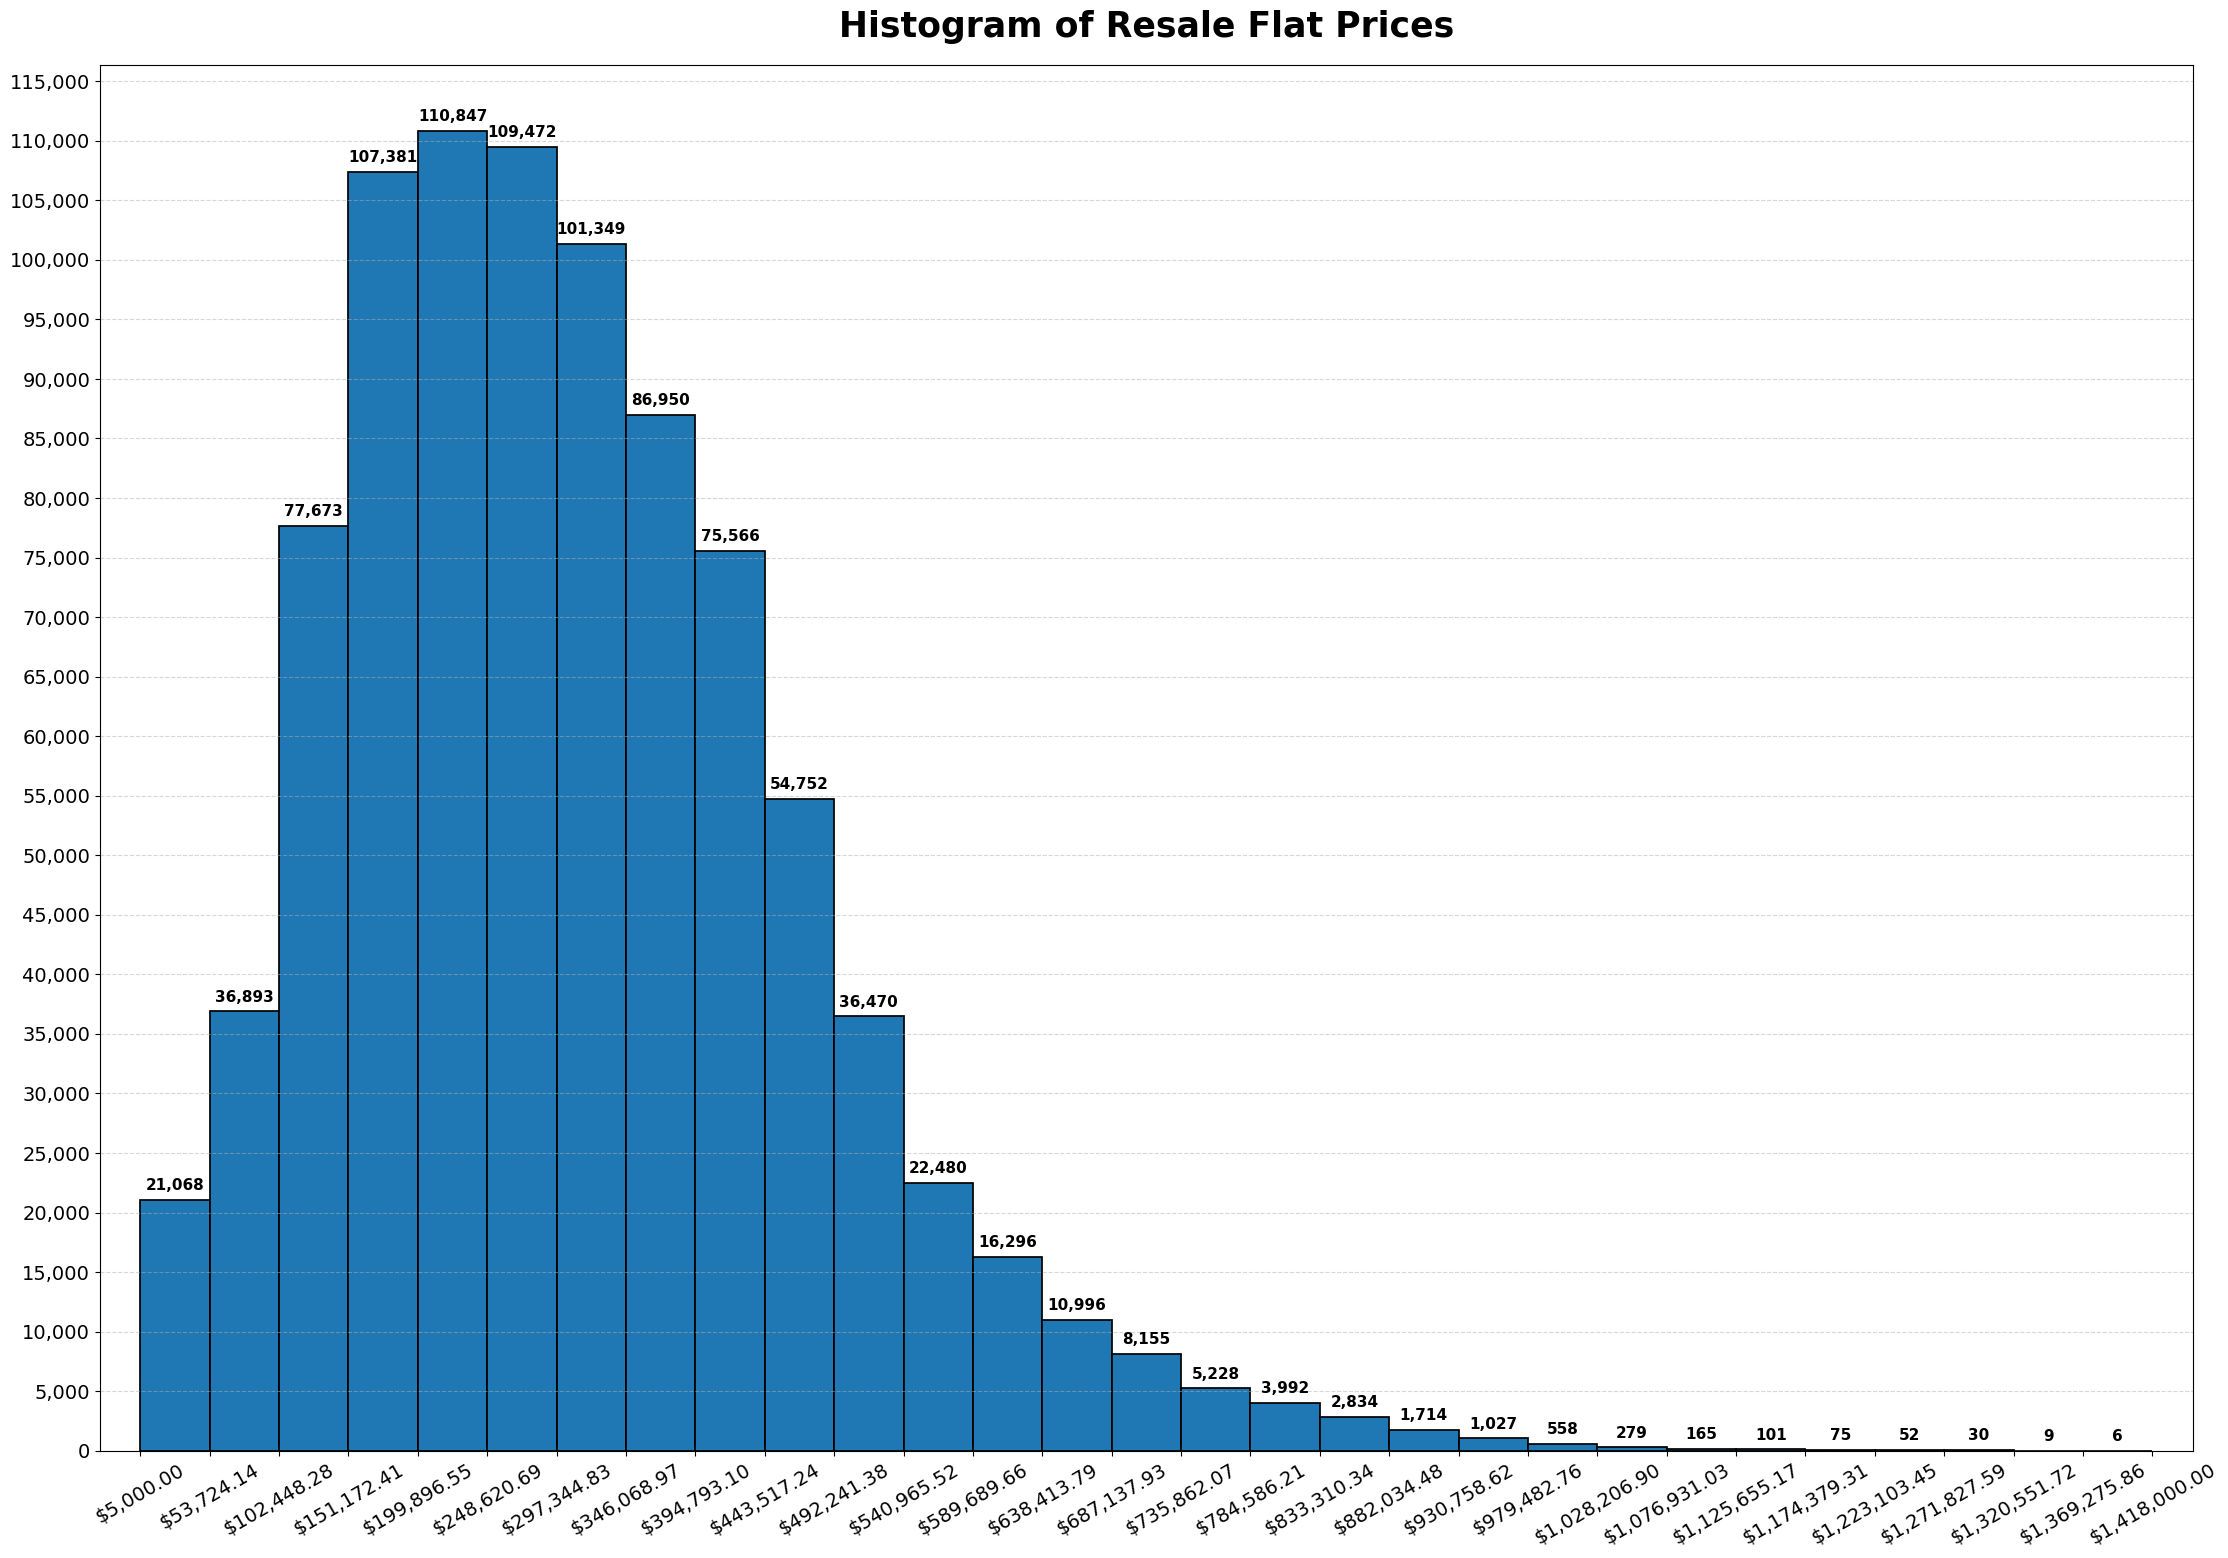

In [12]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.resale_price), bins = 29, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title('Histogram of Resale Flat Prices', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins, rotation = 30)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
plt.yticks(np.linspace(0, 115000, 24))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Prices.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

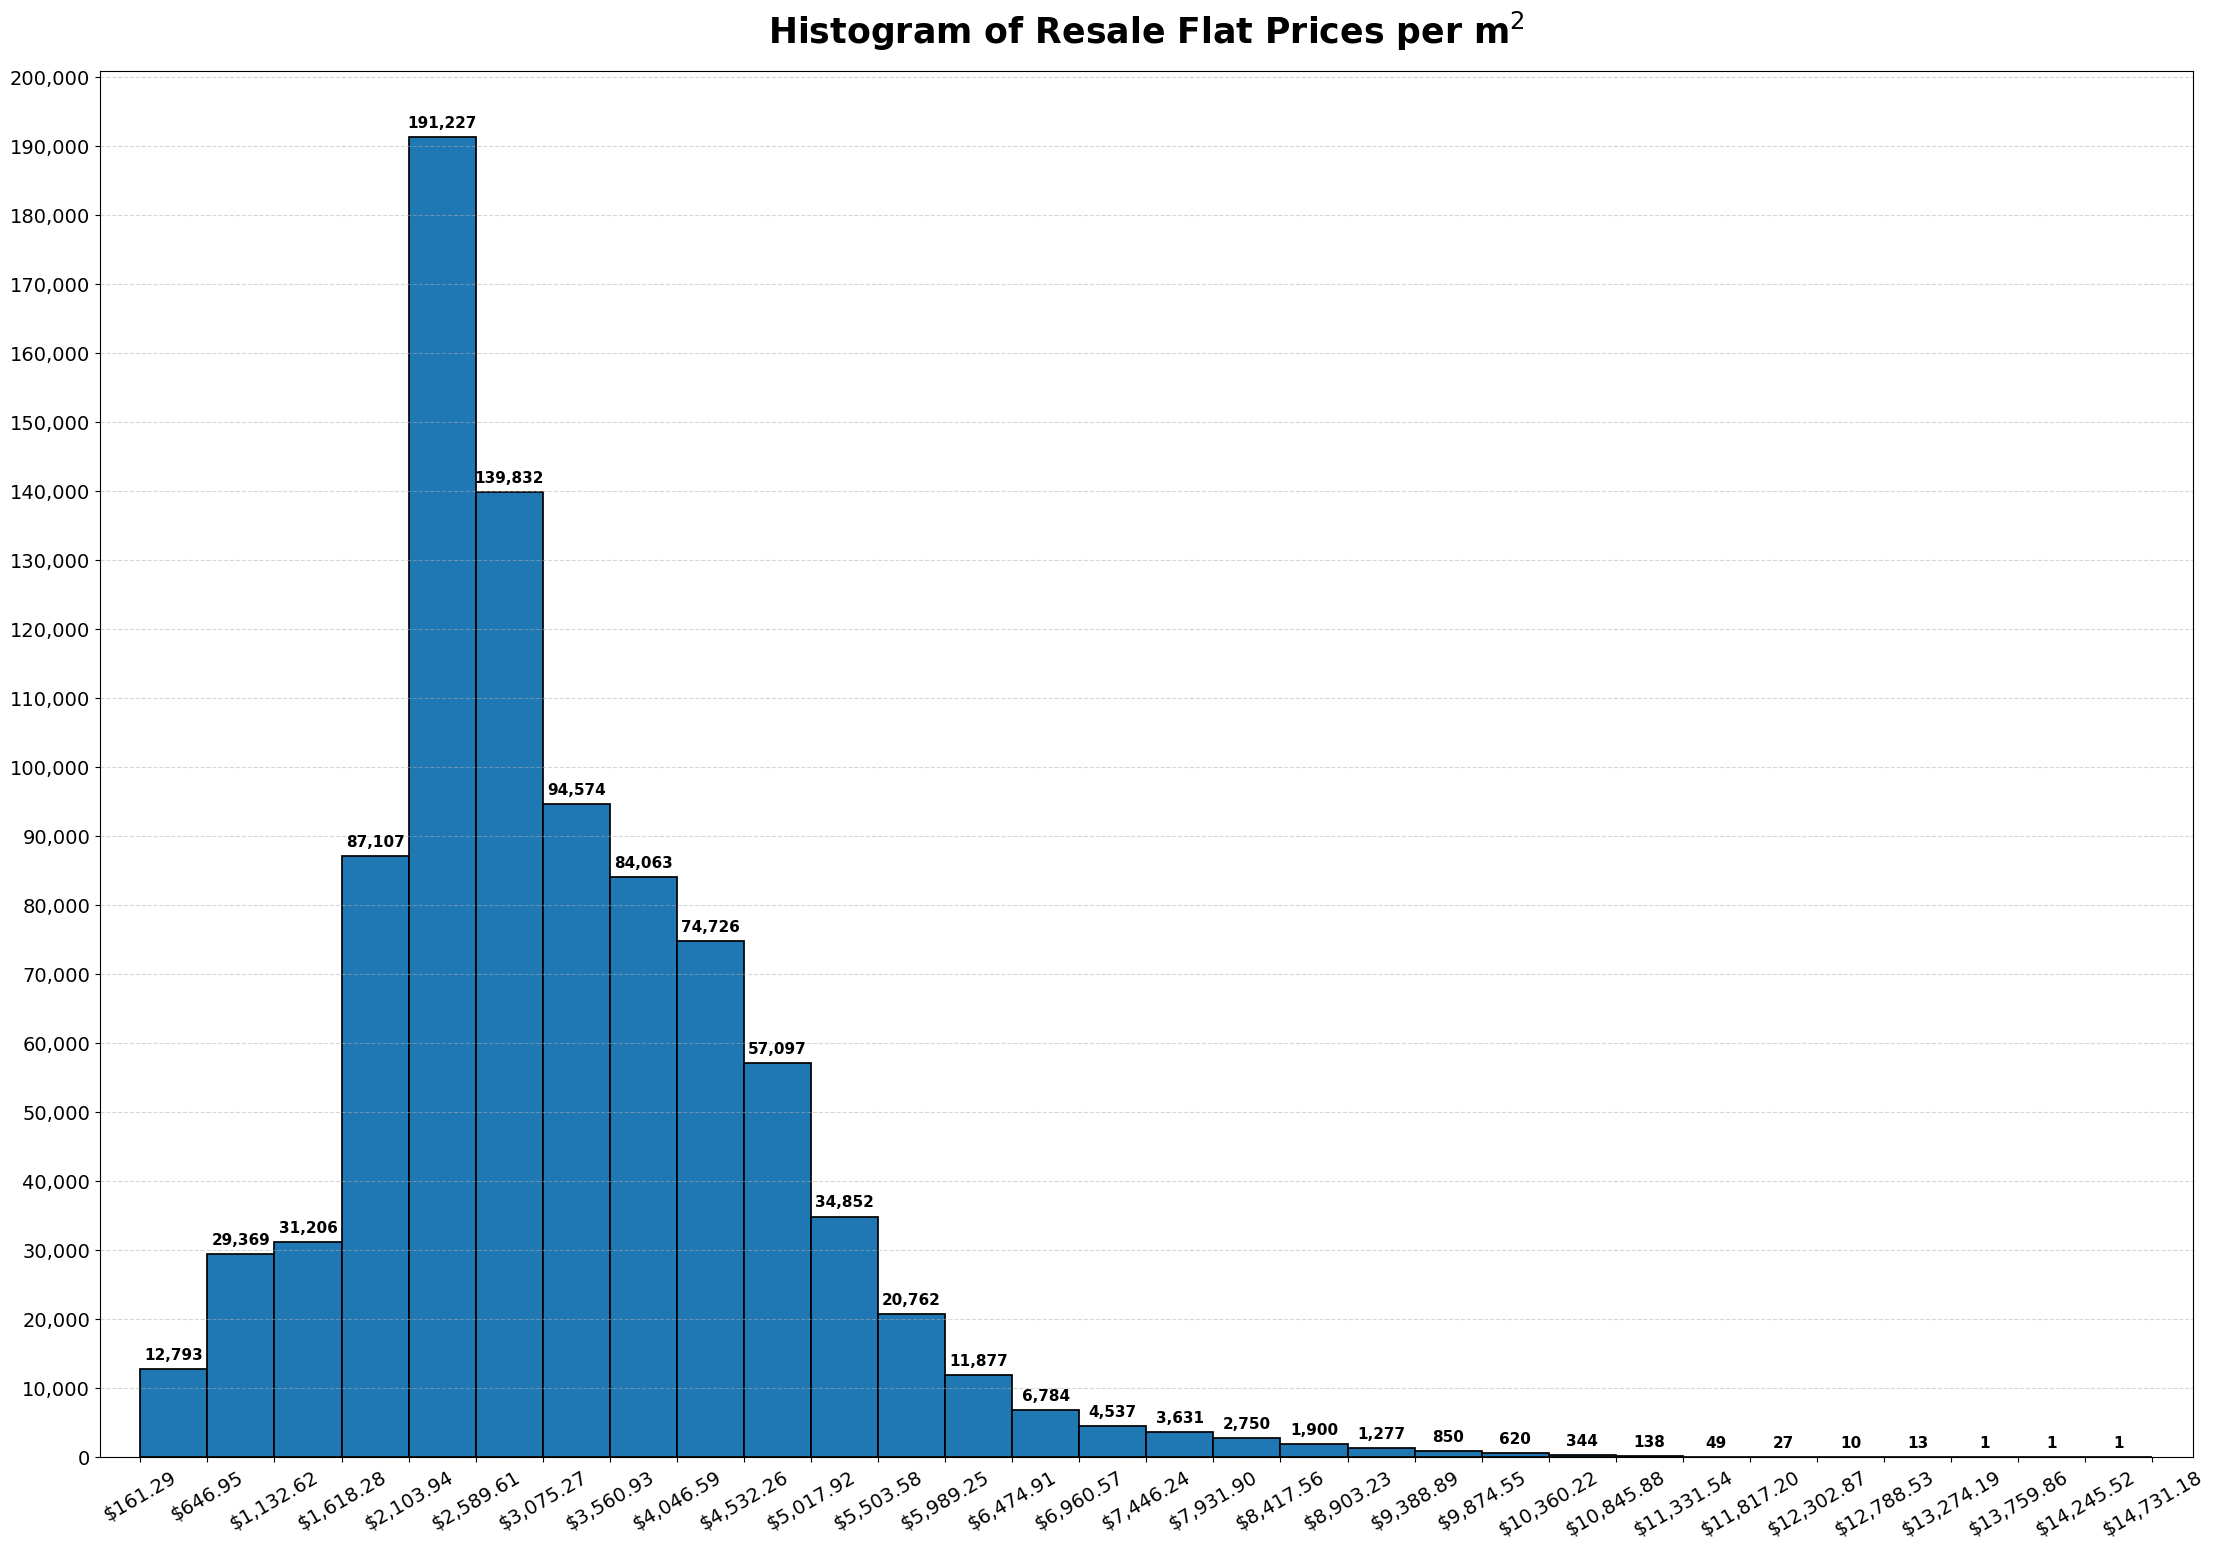

In [13]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.resale_price_per_sqm), bins = 30, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flat Prices per m$^{2}$', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins, rotation = 30)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
plt.yticks(np.linspace(0, 200000, 21))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Prices Per Square Metre.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

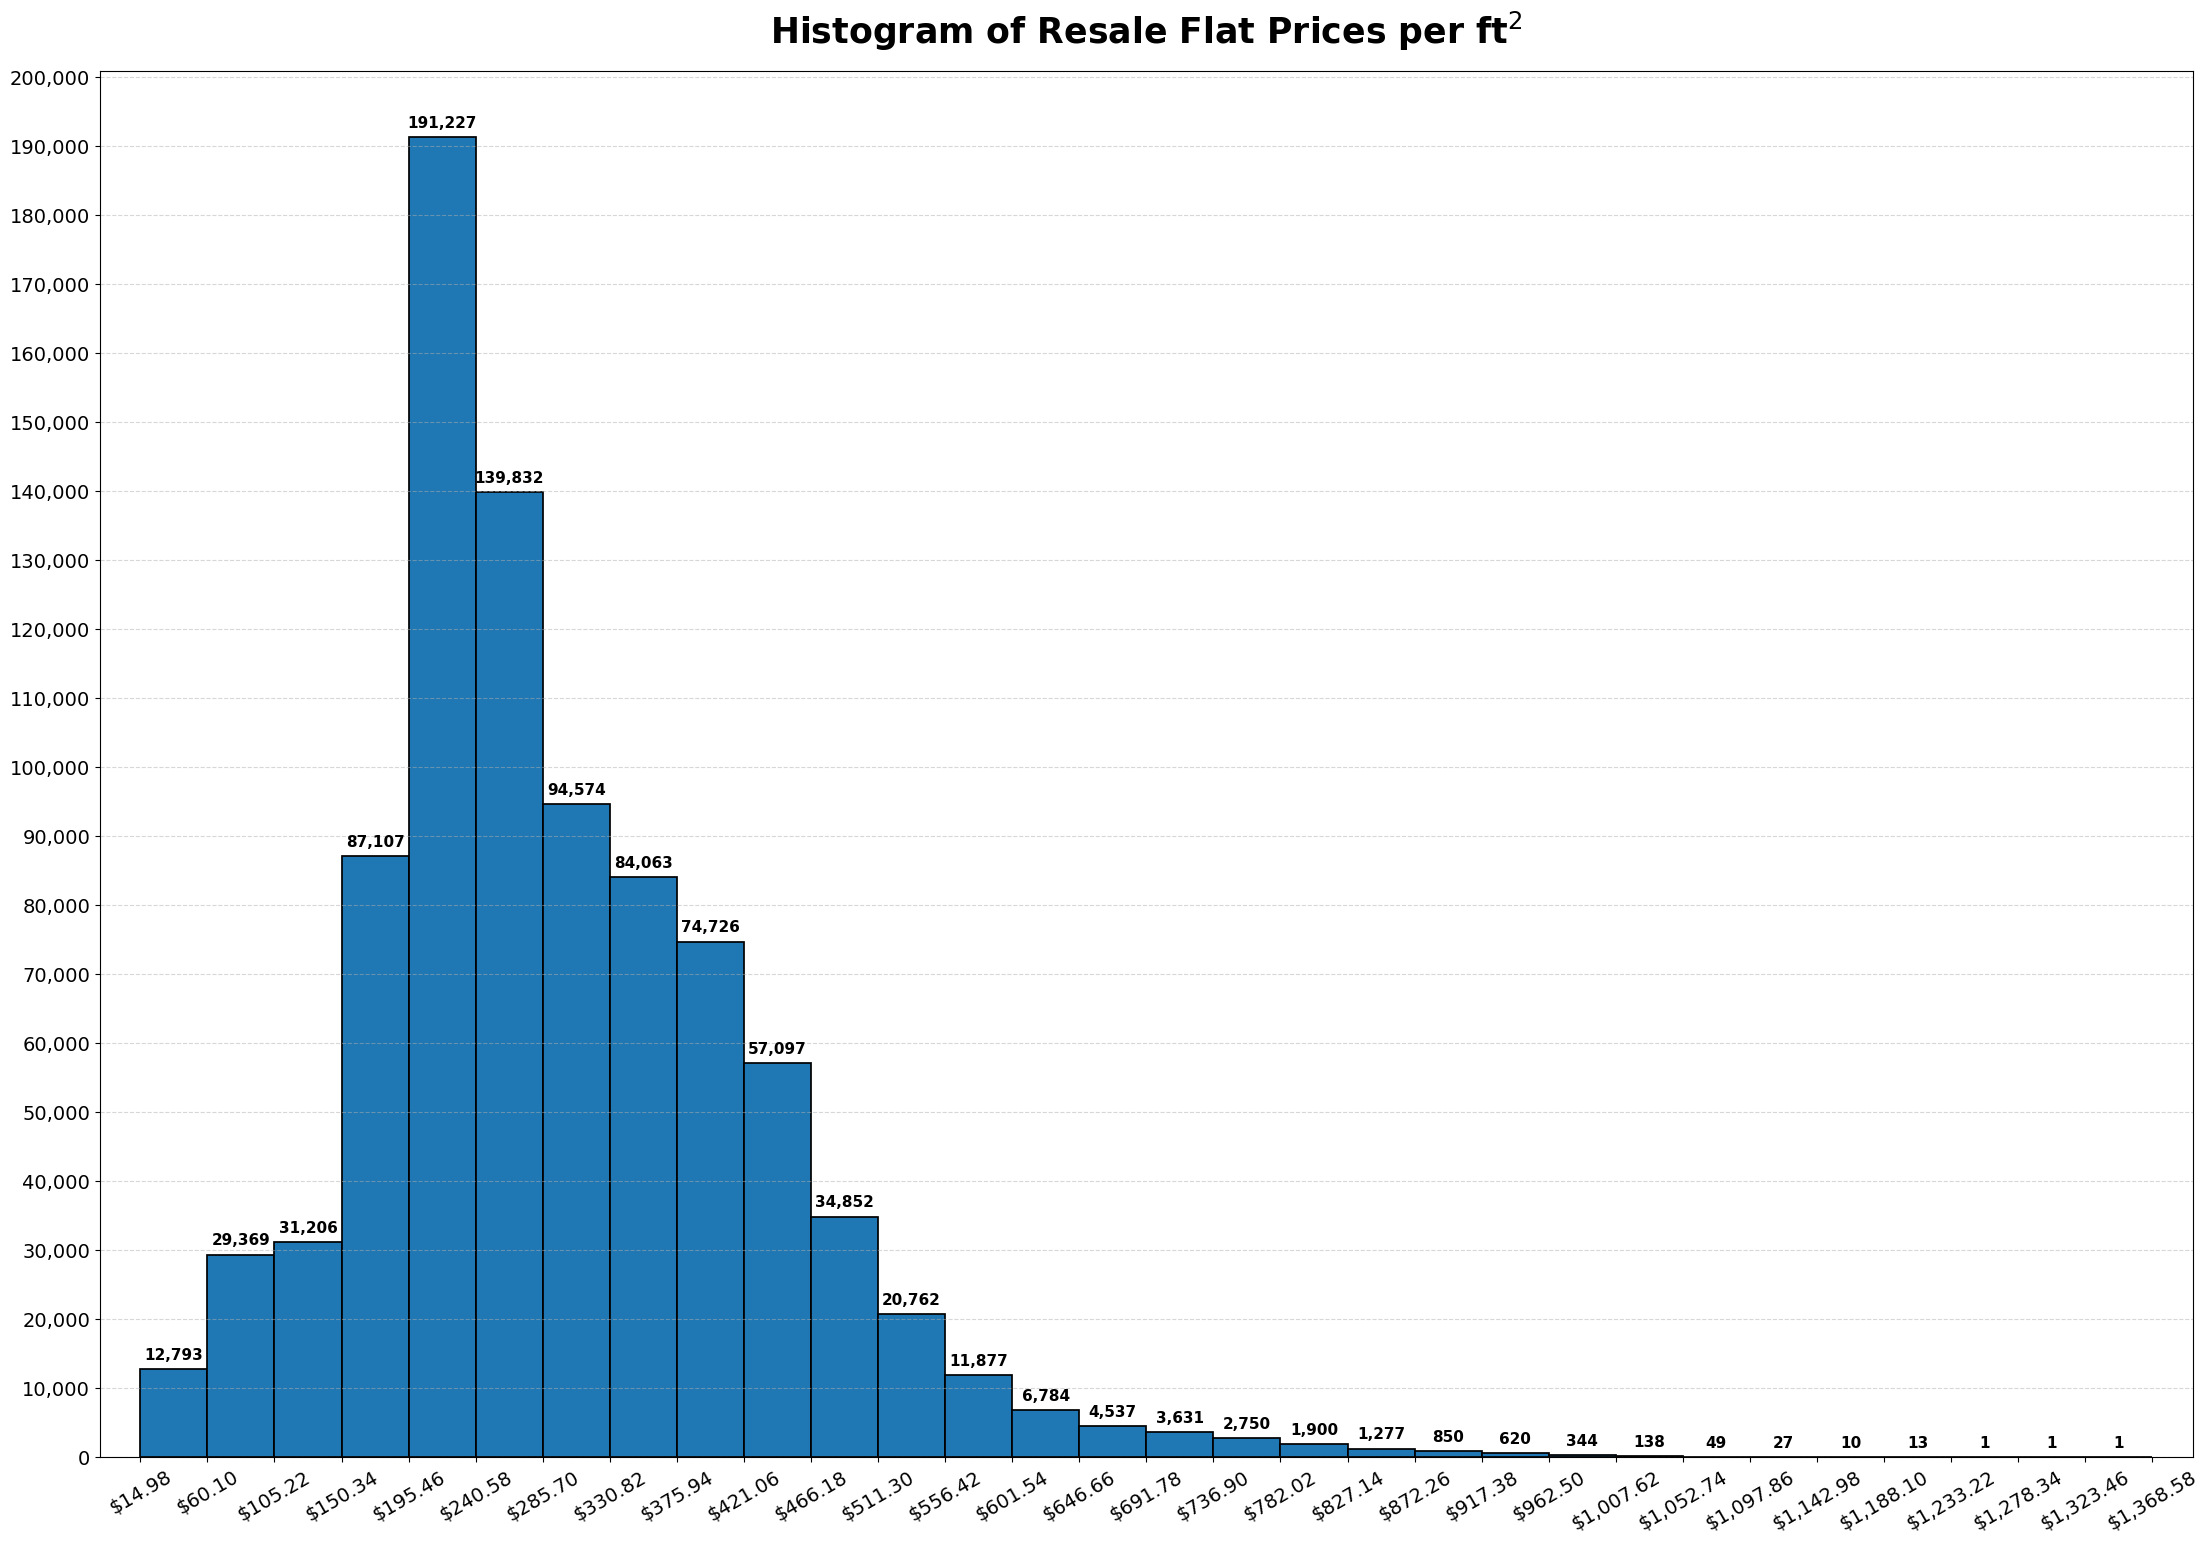

In [14]:
plt.figure(figsize = (27, 18))
plt.margins(x = 0.02, tight = True)
n, bins, containers = plt.hist(sorted(HDB_resale_flat_prices_combined.resale_price_per_sqft), bins = 30, edgecolor = 'black', lw = 1.25, color = 'tab:blue')
plt.title(r'Histogram of Resale Flat Prices per ft$^{2}$', size = 25, weight = 'bold', pad = 20)
plt.xticks(bins, rotation = 30)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
plt.yticks(np.linspace(0, 200000, 21))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.bar_label(containers, labels = [f'{counts:,.0f}' for counts in containers.datavalues], padding = 5, size = 11, weight = 'bold')
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Histograms/Resale Flat Prices Per Square Foot.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

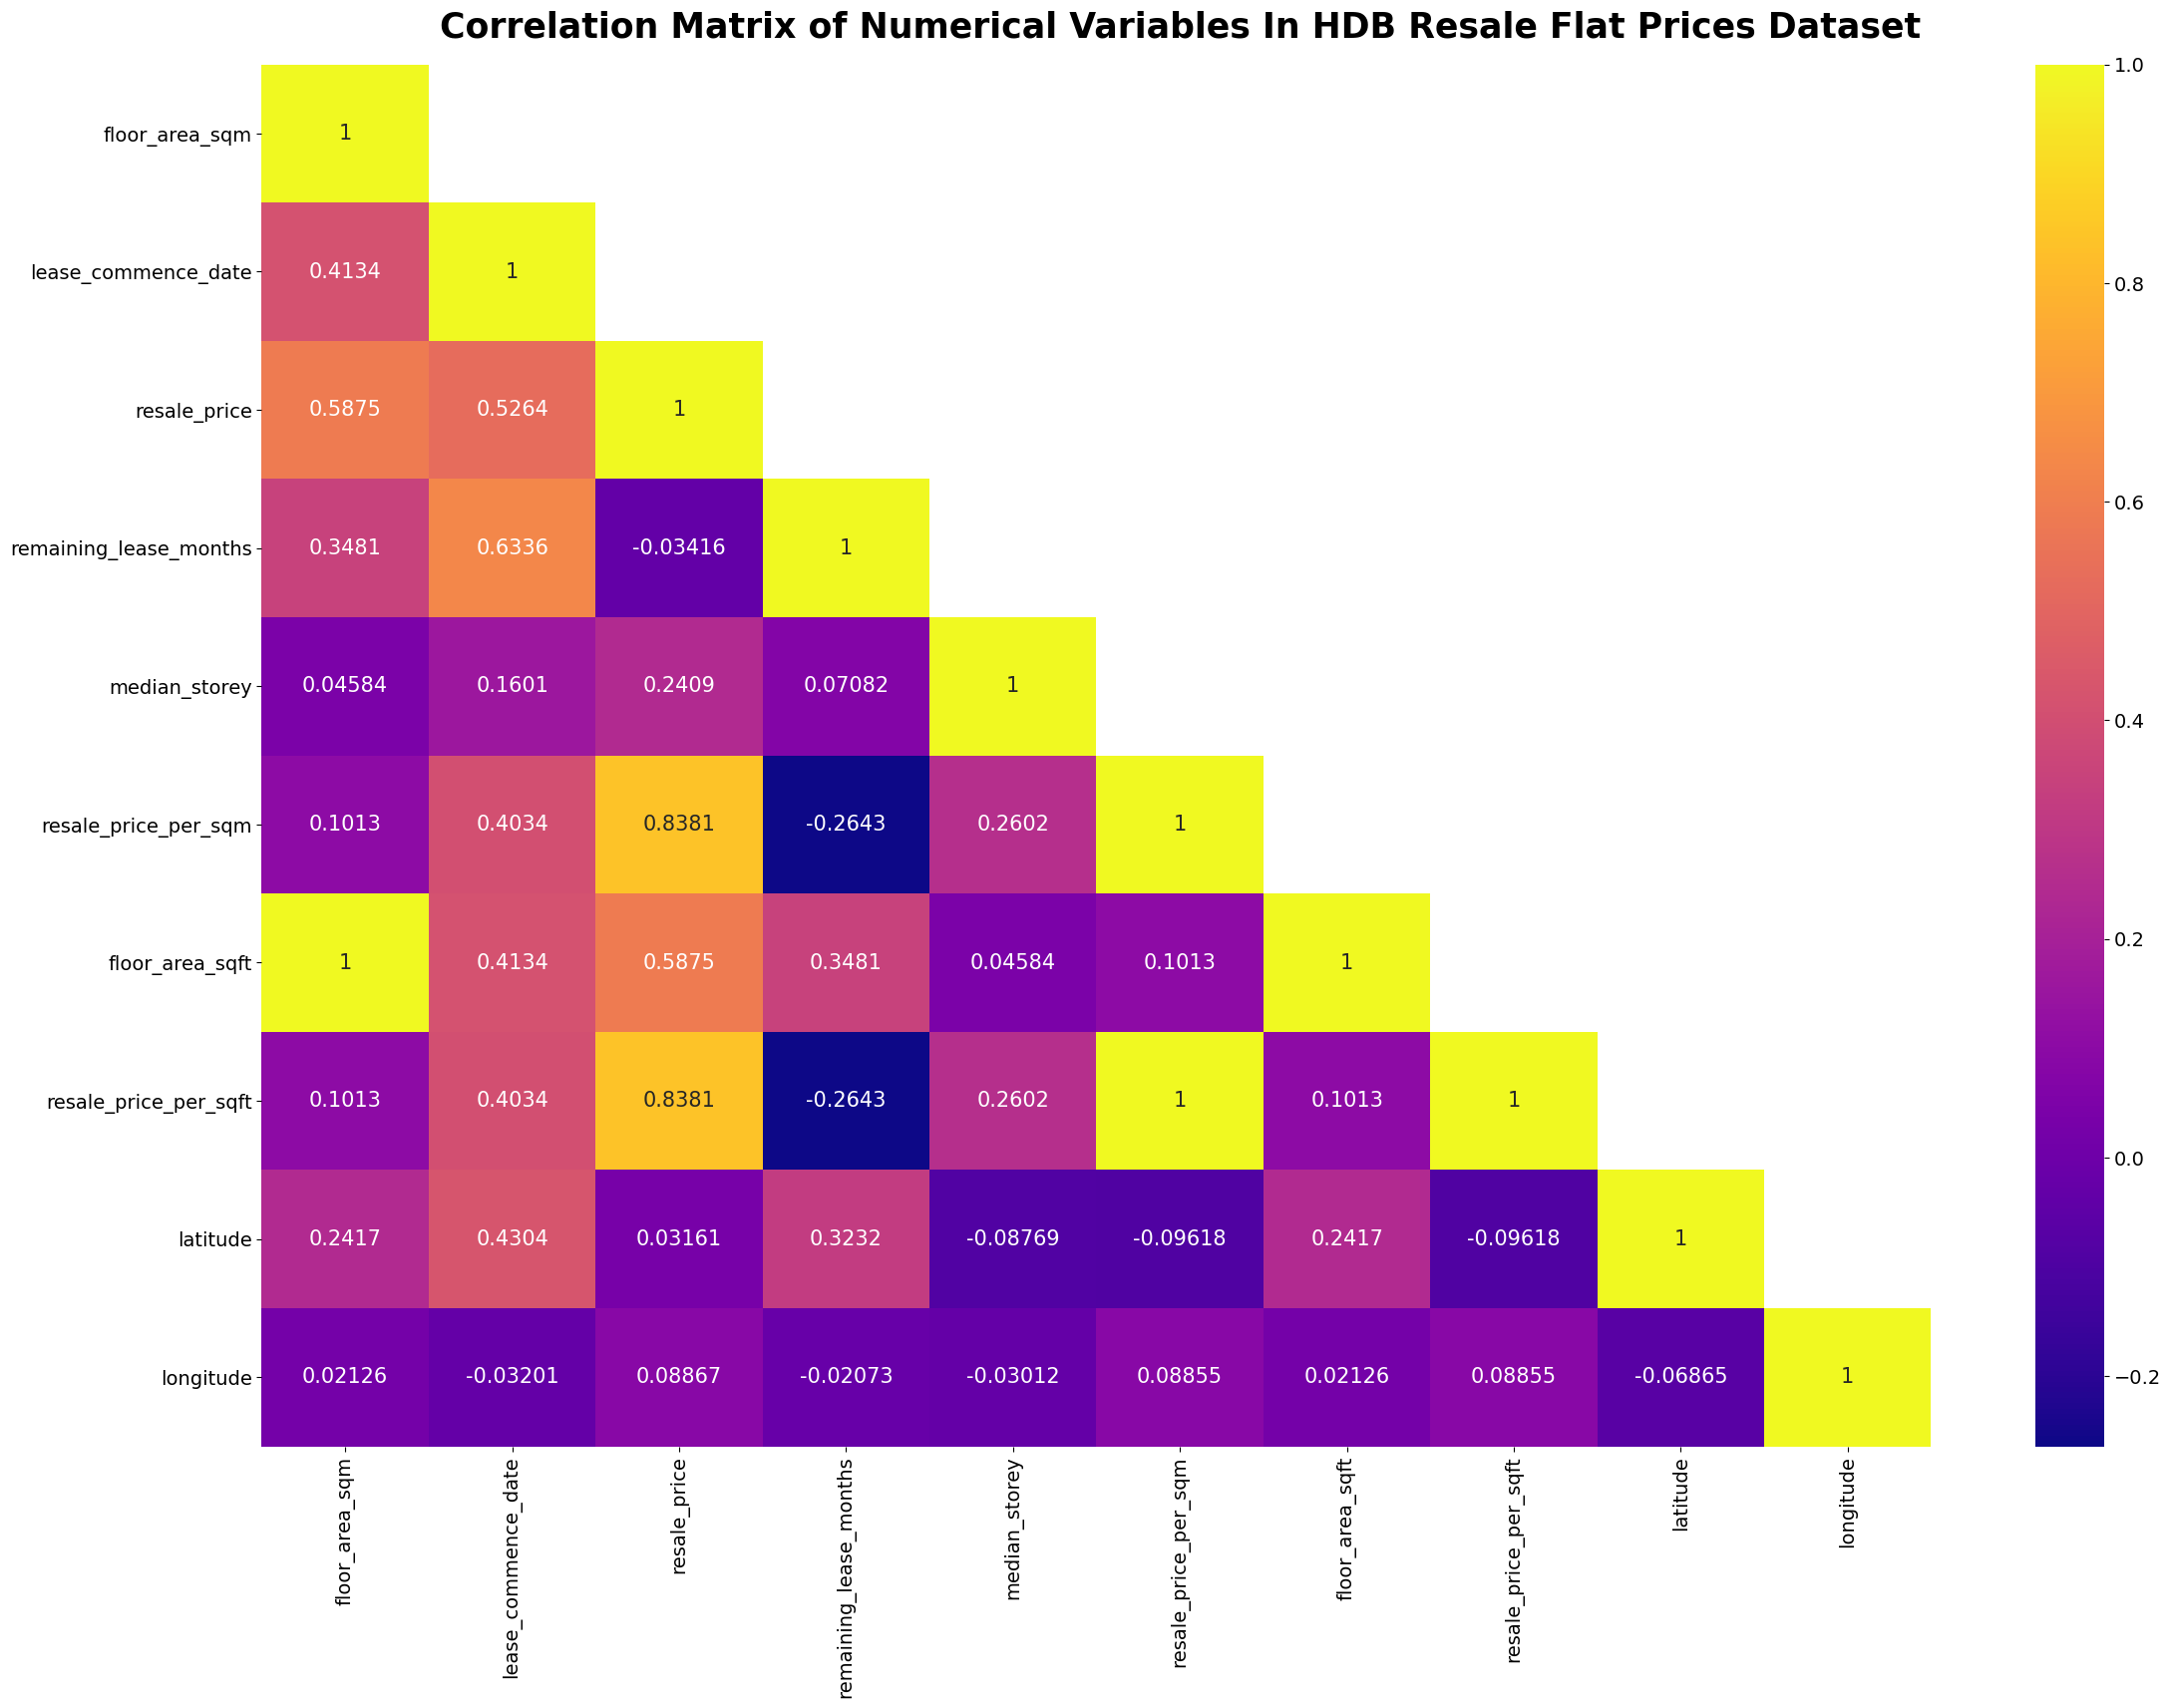

In [15]:
HDB_resale_flat_prices_combined_corr_matrix = HDB_resale_flat_prices_combined.loc[:, HDB_resale_flat_prices_combined.columns != "remaining_lease"].corr(numeric_only = True)
plt.figure(figsize = (27, 18))
plt.title('Correlation Matrix of Numerical Variables In HDB Resale Flat Prices Dataset', size = 25, weight = 'bold', pad = 20, x = 0.55)
plt.xticks(size = 14)
plt.yticks(size = 14)
sns.heatmap(HDB_resale_flat_prices_combined_corr_matrix.where(np.tril(np.ones_like(HDB_resale_flat_prices_combined_corr_matrix, dtype = bool))), 
            cmap = 'plasma', annot = True, fmt = '.4g', annot_kws = {"size": 15})
plt.savefig('Plots/Correlation Matrix.jpeg', dpi = 600, bbox_inches = 'tight')

# **Feature Selection And Data Preparation Prior To Predictive Modelling**

In [16]:
HDB_resale_flat_features = HDB_resale_flat_prices_combined[['town', 'region', 'address', 'latitude', 'longitude', 'remaining_lease_months', 
                                                            'median_storey', 'flat_model_standardized', 'flat_type_standardized', 'floor_area_sqm']]
HDB_resale_flat_features.columns = ['Town', 'Region', 'Address', 'Latitude', 'Longitude', 'Remaining Lease (Months)', 'Median Storey No.', 'Flat Model', 
                                    'Flat Type', 'Floor Area (Square Metres)']
HDB_resale_flat_prices = HDB_resale_flat_prices_combined['resale_price']
HDB_resale_flat_prices.column = 'Resale Price'
feature_datatypes = {'Town': 'category', 'Region': 'category', 'Address': 'category', 'Latitude': 'float64', 'Longitude': 'float64', 'Remaining Lease (Months)': 'int64', 
                     'Median Storey No.': 'int64', 'Flat Model': 'category', 'Flat Type': 'category', 'Floor Area (Square Metres)': 'float64'}
HDB_resale_flat_features = HDB_resale_flat_features.astype(feature_datatypes)
HDB_resale_flat_features.info()
HDB_resale_flat_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892418 entries, 0 to 892417
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Town                        892418 non-null  category
 1   Region                      892418 non-null  category
 2   Address                     892418 non-null  category
 3   Latitude                    892418 non-null  float64 
 4   Longitude                   892418 non-null  float64 
 5   Remaining Lease (Months)    892418 non-null  int64   
 6   Median Storey No.           892418 non-null  int64   
 7   Flat Model                  892418 non-null  category
 8   Flat Type                   892418 non-null  category
 9   Floor Area (Square Metres)  892418 non-null  float64 
dtypes: category(5), float64(3), int64(2)
memory usage: 39.5 MB
<class 'pandas.core.series.Series'>
RangeIndex: 892418 entries, 0 to 892417
Series name: resale_price
Non-Null Count 

## **Allocating 20% of Processed Dataset For Final Model Evaluation**

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV

HDB_resale_flat_features_train, HDB_resale_flat_features_test, HDB_resale_flat_prices_train, HDB_resale_flat_prices_test = train_test_split(
    HDB_resale_flat_features, HDB_resale_flat_prices, test_size = 0.2, random_state = 50)

# **Multiple Linear Regression (multiLR)**

## **Model Building & Training**

In [18]:
import time
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, SGDRegressor

multiLR_start = time.perf_counter()
categorical_transformer = Pipeline(steps = [('One Hot Encoder', OneHotEncoder(handle_unknown = 'infrequent_if_exist'))])
preprocessor = ColumnTransformer(transformers = [('Categorical Transformer', categorical_transformer, make_column_selector(dtype_include = 'category'))], 
                                 remainder = 'passthrough')
multiLR_pipeline = Pipeline(steps = [('Preprocessor', preprocessor), ('Standard Scaler', StandardScaler(with_mean = False)), 
                                     ('Multiple Linear Regression', LinearRegression(n_jobs = -1))])
multiLR_pipeline.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
multiLR_training_duration = time.perf_counter() - multiLR_start

In [19]:
multiLR_pipeline

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical Transformer',
                                                  Pipeline(steps=[('One Hot '
                                                                   'Encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x185299540>)])),
                ('Standard Scaler', StandardScaler(with_mean=False)),
                ('Multiple Linear Regression', LinearRegression(n_jobs=-1))])

## **Model Evaluation Using Root Mean Squared Error (RMSE) & Adjusted $R^{2}$**

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

multiLR_prediction = pd.Series(multiLR_pipeline.predict(HDB_resale_flat_features_test))
multiLR_rmse = mean_squared_error(HDB_resale_flat_prices_test, multiLR_prediction, squared = False)
multiLR_r2 = r2_score(HDB_resale_flat_prices_test, multiLR_prediction, multioutput = 'variance_weighted')

## **Tracking The Performance Metrics of Each Model In A DataFrame**

In [ ]:
performance_metrics = pd.DataFrame(columns = ['Model', 'Training Duration', 'RMSE', 'Adjusted R-Squared'])
performance_metrics.loc['Basic Linear Regression'] = ['Basic Multiple Linear Regression', multiLR_training_duration,
                                                      multiLR_rmse, multiLR_r2]
performance_metrics

# **Basic Decision Tree Regression (DTR)**

## **Hyperparameter Tuning To Find The Decision Tree Model Having The Optimal Max Depth**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DTR_start = time.perf_counter()
DTR_pipeline = Pipeline(steps = [('Preprocessor', preprocessor), ('Standard Scaler', StandardScaler(with_mean = False)), 
                                 ('DecisionTreeRegressor', DecisionTreeRegressor(random_state = 50))])
DTR_hyperparam_grid = {'DecisionTreeRegressor__max_depth': np.linspace(start = 50, stop = 100, num = 26, dtype = int)}
DTR_with_GridSearch = GridSearchCV(estimator = DTR_pipeline, param_grid = DTR_hyperparam_grid, scoring = 'neg_root_mean_squared_error', 
                                   cv = 8, n_jobs = -1, return_train_score = True)
DTR_with_GridSearch.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
DTR_train_duration = time.perf_counter() - DTR_start

In [ ]:
DTR_best_prediction = pd.Series(DTR_with_GridSearch.predict(HDB_resale_flat_features_test))
DTR_best_rmse = mean_squared_error(HDB_resale_flat_prices_test, DTR_best_prediction, squared = False)
DTR_best_r2 = r2_score(HDB_resale_flat_prices_test, DTR_best_prediction, multioutput = 'variance_weighted')

In [ ]:
performance_metrics.loc['Decision Tree Regression'] = ['Decision Tree Regression With Hyperparameter Tuning', 
                                                       DTR_train_duration, DTR_best_rmse, DTR_best_r2]
performance_metrics

In [ ]:
DTR_with_GridSearch.best_estimator_

In [ ]:
DTR_max_depth = []
for hyperparam in DTR_with_GridSearch.cv_results_['params']:
    DTR_max_depth.append(hyperparam['DecisionTreeRegressor__max_depth'])

DTR_mean_train_score = -DTR_with_GridSearch.cv_results_['mean_train_score']
DTR_std_error_train_score = DTR_with_GridSearch.cv_results_['std_train_score']/np.sqrt(len(DTR_with_GridSearch.cv_results_['std_train_score']))

DTR_mean_test_score = -DTR_with_GridSearch.cv_results_['mean_test_score']
DTR_std_error_test_score = DTR_with_GridSearch.cv_results_['std_test_score']/np.sqrt(len(DTR_with_GridSearch.cv_results_['std_test_score']))

plt.figure(figsize = (27, 18))
plt.title('Decision Tree Regression Grid Search Validation Curves', size = 25, weight = 'bold', pad = 20)
plt.plot(DTR_max_depth, DTR_mean_train_score, 'D-', color = 'C1', label = 'Training Scores')
plt.plot(DTR_max_depth, DTR_mean_test_score, 'D-', color = 'C0', label = 'Cross-Validation Scores')

plt.fill_between(DTR_max_depth, DTR_mean_train_score - DTR_std_error_train_score, DTR_mean_train_score + DTR_std_error_train_score,
                 alpha = 0.2, color = 'C1')
plt.fill_between(DTR_max_depth, DTR_mean_test_score - DTR_std_error_test_score, DTR_mean_test_score + DTR_std_error_test_score,
                 alpha = 0.2, color = 'C0')

plt.xlabel('Max Depth', size = 14, labelpad = 15)
plt.xticks(DTR_max_depth)
plt.xlim(np.min(DTR_max_depth), np.max(DTR_max_depth))
plt.ylabel('Root Mean Squared Error (RMSE)', size = 14, labelpad = 15)
plt.yticks(np.linspace(7500, 37500, 13))
plt.ylim(6000, 38000)
plt.legend(loc = 'best', fontsize = 14)
plt.grid(which = 'both', axis = 'y', alpha = 0.5, linestyle = '--')
plt.savefig('Plots/Validation Curves/Decision Tree Regression With Hyperparameter Tuning Using Grid Search.jpeg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [ ]:
DTR_cv_test_results = pd.DataFrame({'Max Depth': DTR_max_depth, 'Mean Train RMSE': DTR_mean_train_score, 'Train RMSE Standard Error': DTR_std_error_train_score, 
                                    'Mean CV RMSE': DTR_mean_test_score, 'Test CV Standard Error': DTR_std_error_test_score})
DTR_cv_test_results

# **Random Forest Regression (RFR)**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFR_start = time.perf_counter()
RFR_pipeline = Pipeline(steps = [('Preprocessor', preprocessor), ('Standard Scaler', StandardScaler(with_mean = False)), 
                                 ('RandForestRegressor', RandomForestRegressor(random_state = 50, n_jobs = -1, max_samples = 0.4, verbose = 2))])
RFR_hyperparam_grid = {'RandForestRegressor__n_estimators': [50, 75, 100, 125, 150, 175], 'RandForestRegressor__max_depth': np.linspace(start = 5, stop = 30, num = 6, dtype = int)}
RFR_with_GridSearch = GridSearchCV(estimator = RFR_pipeline, param_grid = RFR_hyperparam_grid, scoring = 'neg_root_mean_squared_error', 
                                   cv = 8, n_jobs = -1, return_train_score = True)
RFR_with_GridSearch.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
RFR_train_duration = time.perf_counter() - RFR_start

In [ ]:
RFR_best_prediction = pd.Series(RFR_with_GridSearch.predict(HDB_resale_flat_features_test))
RFR_best_rmse = mean_squared_error(HDB_resale_flat_prices_test, RFR_best_prediction, squared = False)
RFR_best_r2 = r2_score(HDB_resale_flat_prices_test, RFR_best_prediction, multioutput = 'variance_weighted')

In [ ]:
performance_metrics.loc['Random Forest Regression'] = ['Random Forest Regression With Hyperparameter Tuning', 
                                                       RFR_train_duration, RFR_best_rmse, RFR_best_r2]
performance_metrics

In [ ]:
RFR_with_GridSearch.best_estimator_

In [ ]:
RFR_num_trees = []
RFR_max_depth = []
for hyperparams in RFR_with_GridSearch.cv_results_['params']:
    RFR_num_trees.append(hyperparams['RandForestRegressor__n_estimators'])
    RFR_max_depth.append(hyperparams['RandForestRegressor__max_depth'])
RFR_cv_test_results = pd.DataFrame({'Num of Estimators': RFR_num_trees, 'Max Depth': RFR_max_depth, 'Mean CV RMSE': -RFR_with_GridSearch.cv_results_['mean_test_score'], 
                                    'CV RMSE Standard Error': RFR_with_GridSearch.cv_results_['std_test_score']/np.sqrt(len(RFR_with_GridSearch.cv_results_['std_test_score']))})
RFR_cv_test_results

# **Light Gradient Boosting Machine (LGBM) Regression**

In [ ]:
from lightgbm import LGBMRegressor

LGBM_start = time.perf_counter()
LGBM_pipeline = Pipeline(steps = [('LGBMRegressor', LGBMRegressor(random_state = 50, n_jobs = -1))])
LGBM_hyperparam_grid = {'LGBMRegressor__num_leaves': [512, 1024, 2048, 4096],
                        'LGBMRegressor__n_estimators': [100, 200, 300, 400, 500, 600, 700]}
LGBM_with_GridSearch = GridSearchCV(estimator = LGBM_pipeline, param_grid = LGBM_hyperparam_grid, scoring = 'neg_root_mean_squared_error', 
                                    cv = 8, n_jobs = -1, return_train_score = True)
LGBM_with_GridSearch.fit(HDB_resale_flat_features_train, HDB_resale_flat_prices_train)
LGBM_train_duration = time.perf_counter() - LGBM_start

In [ ]:
LGBM_best_prediction = pd.Series(LGBM_with_GridSearch.predict(HDB_resale_flat_features_test))
LGBM_best_rmse = mean_squared_error(HDB_resale_flat_prices_test, LGBM_best_prediction, squared = False)
LGBM_best_r2 = r2_score(HDB_resale_flat_prices_test, LGBM_best_prediction, multioutput = 'variance_weighted')

In [ ]:
performance_metrics.loc['Light Gradient Boosting Machine (LGBM) Regression'] = ['LightGBM Regression With Hyperparameter Tuning', 
                                                                                LGBM_train_duration, LGBM_best_rmse, LGBM_best_r2]
performance_metrics

In [ ]:
LGBM_with_GridSearch.best_estimator_

In [ ]:
LGBM_num_leaves = []
LGBM_num_trees = []
for hyperparams in LGBM_with_GridSearch.cv_results_['params']:
    LGBM_num_leaves.append(hyperparams['LGBMRegressor__num_leaves'])
    LGBM_num_trees.append(hyperparams['LGBMRegressor__n_estimators'])
LGBM_cv_test_results = pd.DataFrame({'Max Num of Leaves': LGBM_num_leaves, 'Num of Estimators': LGBM_num_trees, 'Mean CV RMSE': -LGBM_with_GridSearch.cv_results_['mean_test_score'], 
                                     'CV RMSE Standard Error': LGBM_with_GridSearch.cv_results_['std_test_score']/np.sqrt(len(LGBM_with_GridSearch.cv_results_['std_test_score']))})
LGBM_cv_test_results

## **Interpreting The Resultant LGBM Regression Model**

In [ ]:
import shap

LGBM_explainer = shap.TreeExplainer(LGBM_with_GridSearch.best_estimator_.named_steps['LGBMRegressor'])
LGBM_shap_values = LGBM_explainer.shap_values(HDB_resale_flat_features_test)
LGBM_shap_values_df = pd.DataFrame(LGBM_shap_values, columns = 'shap_' + HDB_resale_flat_features_test.columns)
HDB_resale_flat_features_test_with_shap = pd.concat([HDB_resale_flat_features_test.reset_index(drop = True), LGBM_shap_values_df], axis = 1)
HDB_resale_flat_features_test_with_shap

In [ ]:
shap.summary_plot(shap_values = LGBM_shap_values, features = HDB_resale_flat_features_test, plot_type = 'dot')

In [ ]:
shap.summary_plot(shap_values = LGBM_shap_values, features = HDB_resale_flat_features_test, plot_type = 'bar', plot_size = (9, 6))

In [ ]:
import ipywidgets

@ipywidgets.interact
def shap_decision_plot(HDB_Flat = ipywidgets.IntSlider(value = 0, min = 0, max = len(HDB_resale_flat_features_test.index) - 1, step = 1, layout = ipywidgets.Layout(width = 'auto'))):
    actual = HDB_resale_flat_prices_test.iloc[HDB_Flat]
    predicted = LGBM_explainer.expected_value + sum(LGBM_shap_values[HDB_Flat])
    error = predicted - actual
    shap.decision_plot(LGBM_explainer.expected_value, LGBM_shap_values[HDB_Flat, :], HDB_resale_flat_features_test.iloc[HDB_Flat, :])
    print('Actual Price = ${:0.2f}, Predicted Price = ${:1.2f}, Error = ${:2.2f}'.format(actual, predicted, error))